In [1]:
# %matplotlib notebook
import uproot as up
import numpy as np
import pandas as pd
import awkward as ak
import os
import sys
import matplotlib.cm as cm

sys.path.append("/g/g20/lenardo1/software/root_install/lib")

# print(os.environ.get("PYTHONPATH"))
# !bash ~/.profile.linux
# print(os.environ.get("PYTHONPATH"))

# import ROOT

datadir = '/p/lustre1/lenardo1/simulations/KTonXe/ElectronGammaPositionDiscrimination/'


# Instructions for generating MC data

## Simulation files and data processing

To run the simulations, KTonXe project in BACCARAT. Specific macros are:
- `KTonXe/Macros/LiquidXe_Electrons_Qbb_over_2.mac`
- `KTonXe/Macros/LiquidXe_Gammas_214Bi_energy_pointlike.mac` 

Then need to process into ROOT files:
`./tools/BaccRootConverter \<file\>`

## Reducing data

Then, need to process into reduced data. Done using the `XeNeuSimsAnalysisEnvironment`, with the `XeNeuSimpleTrackAnalysisTemplate.C` macro file. This file is in `BACCARAT/tools/`

Syntax is:
`root -l -q 'XeNeuSimpleTrackAnalysisTemplate.C("input_filename","output_filename.root")'`

Notes:
- Requires single quotes around the macro name
- No ".root" file extensions in the input file
- If you get errors, try recompiling the XeNeuSimsAnalysis_cc.so library (by running `.L XeNeuSimsAnalysis.cc++` inside a ROOT terminal)





In [2]:

# ingest electrons data
# electrons_data_filename = 'KTonXe_liquidXe_TwoElectrons_Qbb_over_2_1997003440.root'
# electrons_data_filename = 'KTonXe_liquidXe_TwoElectrons_Qbb_over_2__2e5evts_1428342293_REDUCED.root'
electrons_data_filename = 'KTonXe_liquidXe_TwoElectrons_Qbb_over_2__1e4evts_SHORTCUTS_1675286877_REDUCED.root'
electrons_data_filename = 'KTonXe_liquidXe_TwoElectrons_Qbb_over_2__1e5evts_SHORTCUTS_968114238_REDUCED.root'
# electrons_data_filename = 'KTonXe_liquidXe_TwoElectrons_Qbb_over_2__1e4evts_0p1umCuts_899584083_REDUCED.root'

print('Opening file...')
electrons_file = up.open(datadir + electrons_data_filename)
electrons_tree = electrons_file['data']
print(electrons_tree.keys())
# print(electrons_tree['Event/tracks/tracks.steps'].interpretation)

print('Converting to np arrays...')
electrons_data = electrons_tree.arrays(library='np', entry_stop=-1)
print('Done.\n')






Opening file...
['stepX', 'stepY', 'stepZ', 'stepEnergy_keV', 'stepTime_ns']
Converting to np arrays...
Done.



In [3]:
print(len(electrons_data['stepEnergy_keV']))

99999


In [4]:
def ComputeRange(x,y,z):
    # print(len(x))
    total_range = 0.
    for i in range(1,len(x)):
        total_range += np.sqrt( (x[i]-x[i-1])**2 + (y[i]-y[i-1])**2 + (z[i]-z[i-1])**2 )
        
    return total_range

def ComputeVolume(x,y,z):
    # print(len(x))
    max_dist = 0.
    for i in range(1,len(x)-1):
        for j in range(i+1, len(x)):
            this_dist = np.sqrt( (x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2 )
            if this_dist > max_dist: max_dist = this_dist
        
    return max_dist

Range of event 8: 3.108mm


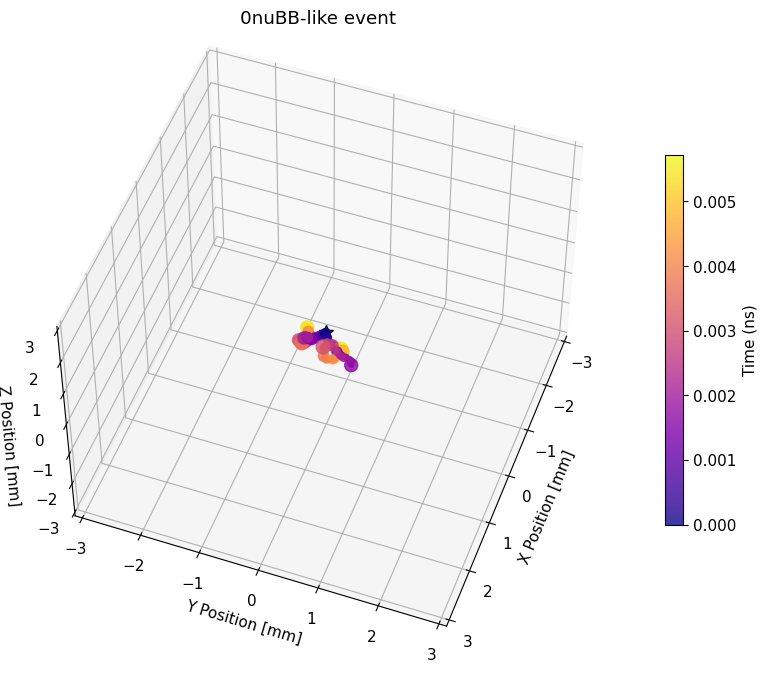

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.size'] = 11

idx = 8

x = electrons_data['stepX'][idx]
y = electrons_data['stepY'][idx]
z = electrons_data['stepZ'][idx]
energy = electrons_data['stepEnergy_keV'][idx]
time = electrons_data['stepTime_ns'][idx]
srt = np.argsort(time)

print('Range of event {}: {:4.4}mm'.format(idx, ComputeRange(x[srt],y[srt],z[srt])))

marker_sizes = (energy - min(energy)) / (max(energy) - min(energy)) * 100
time_normalized = time - min(time) #(time - min(time)) / (max(time) - min(time)) * 200

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x[srt], y[srt], z[srt], s=marker_sizes[srt], c=time_normalized[srt], cmap='plasma', alpha=0.8)
p = ax.plot(np.append([0.],x[srt]), np.append([0.],y[srt]), np.append([0.],z[srt]), '-k', linewidth=1)


# idx = idx+1

x = electrons_data['stepX'][idx+1]
y = electrons_data['stepY'][idx+1]
z = electrons_data['stepZ'][idx+1]
energy = electrons_data['stepEnergy_keV'][idx+1]
time = electrons_data['stepTime_ns'][idx+1]
srt = np.argsort(time)

marker_sizes = (energy - min(energy)) / (max(energy) - min(energy)) * 100
time_normalized = time - min(time) #(time - min(time)) / (max(time) - min(time)) * 200

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x[srt], y[srt], z[srt], s=marker_sizes[srt], c=time_normalized[srt], cmap='plasma', alpha=0.8)
p = ax.plot(np.append([0.],x[srt]), np.append([0.],y[srt]), np.append([0.],z[srt]), '-k', linewidth=1)
p2 = ax.plot(0.,0.,0.,'*',color='k',markersize=10)

box_size = 3.

ax.set_xlim(-box_size,box_size)
ax.set_ylim(-box_size,box_size)
ax.set_zlim(-box_size,box_size)
ax.view_init(elev=90, azim=0)
ax.view_init(elev=50, azim=20)

ax.set_xlabel("X Position [mm]")
ax.set_ylabel("Y Position [mm]")
ax.set_zlabel("Z Position [mm]")
ax.set_title("0nuBB-like event")

cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Time (ns)")

plt.savefig('plots/0nuBB_evt_display_evt_{}_02.png'.format(idx),dpi=200,bbox_inches='tight')


In [6]:
ranges = []
distances = []


for idx in range(len(electrons_data['stepX'])):
    
    if idx%100==0: print('Running evt {}...'.format(idx))
    if idx>1000: break

    x = electrons_data['stepX'][idx]
    y = electrons_data['stepY'][idx]
    z = electrons_data['stepZ'][idx]
    energy = electrons_data['stepEnergy_keV'][idx]
    time = electrons_data['stepTime_ns'][idx]
    srt = np.argsort(time)

    thisrange = ComputeRange(x[srt],y[srt],z[srt])
    thisdistance = ComputeVolume(x[srt], y[srt], z[srt])
    ranges.append(thisrange)
    distances.append(thisdistance)
    
    
    
    # print('Range of event {}: {:4.4}mm'.format(idx, thisrange))

ranges = np.array(ranges)
distances = np.array(distances)

Running evt 0...
Running evt 100...
Running evt 200...
Running evt 300...
Running evt 400...
Running evt 500...
Running evt 600...
Running evt 700...
Running evt 800...
Running evt 900...
Running evt 1000...


Average range of 1.2285 MeV eletron: 7.582 mm
Avg max distance: 4.414mm


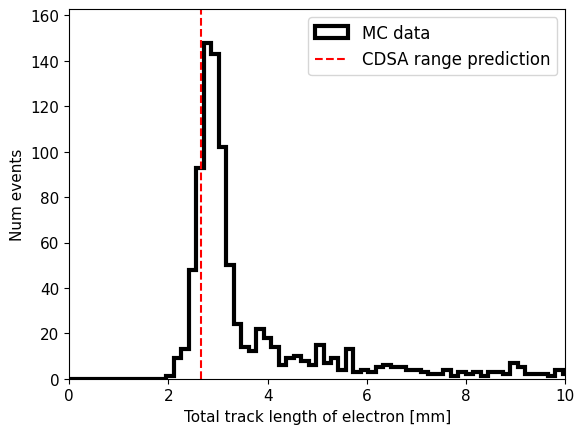

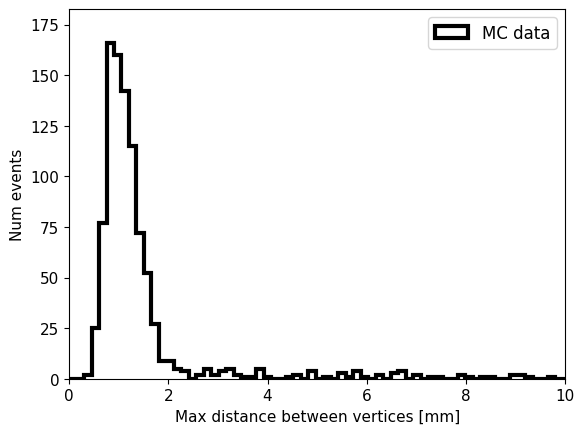

In [7]:


print('Average range of 1.2285 MeV eletron: {:4.4} mm'.format(np.mean(ranges)))

vals, bins, patches = plt.hist(ranges, bins=np.linspace(0.,30.,200), histtype='step', color='k', linewidth=3, label='MC data')

maxy = np.max(vals)

plt.plot(np.ones(10)*2.66, np.linspace(0.,maxy*1.1,10), '--r', label='CDSA range prediction')

plt.ylim(0.,maxy*1.1)
plt.xlim(0.,10.)
plt.xlabel('Total track length of electron [mm]')
plt.ylabel('Num events')

# xfit = np.linspace(0.,50.)
# yfit = 142.*np.exp(-xfit/8.9)
# plt.plot(xfit,yfit,'-r', label='Exp. fit with mean = 8.9 cm')
plt.legend(fontsize=12)
plt.savefig('plots/electron_range_values_sims_vs_CDSA.png',dpi=200,bbox_inches='tight')

plt.figure(2)
print('Avg max distance: {:4.4}mm'.format(np.mean(distances)))

bins = np.linspace(0.,30.,200)
# bins = 200
vals, bins, patches = plt.hist(distances, bins=bins, histtype='step', color='k', linewidth=3, label='MC data')

maxy = np.max(vals)

# plt.plot(np.ones(10)*2.66, np.linspace(0.,maxy*1.1,10), '--r', label='CDSA range prediction')

plt.ylim(0.,maxy*1.1)
plt.xlim(0.,10.)
plt.xlabel('Max distance between vertices [mm]')
plt.ylabel('Num events')

# xfit = np.linspace(0.,50.)
# yfit = 142.*np.exp(-xfit/8.9)
# plt.plot(xfit,yfit,'-r', label='Exp. fit with mean = 8.9 cm')
plt.legend(fontsize=12)
plt.savefig('plots/electron_event_max_dist.png',dpi=200,bbox_inches='tight')


# plt.savefig('gamma_distance_to_first_scatter.png', dpi=200, bbox_inches='tight')
    

In [8]:
# ingest electrons data
# electrons_data_filename = 'KTonXe_liquidXe_TwoElectrons_Qbb_over_2_1997003440.root'
gammas_data_filename = 'KTonXe_liquidXe_Bi214gammas_1e5evts_1565474605_REDUCED.root'
gammas_data_filename = 'KTonXe_liquidXe_Bi214gammas_1e4evts_SHORTCUTS_113725985_REDUCED.root'
gammas_data_filename = 'KTonXe_liquidXe_Bi214gammas_1e4evts_SHORTCUTS_1329303158_REDUCED.root'
gammas_data_filename = 'KTonXe_liquidXe_Bi214gammas_5e4evts_SHORTCUTS_927033683_REDUCED.root'

print('Opening file...')
gammas_file = up.open(datadir + gammas_data_filename)
gammas_tree = gammas_file['data']
print(gammas_tree.keys())
# print(electrons_tree['Event/tracks/tracks.steps'].interpretation)

print('Converting to np arrays...')
gammas_data = gammas_tree.arrays(library='np', entry_stop=-1)
print('Done.\n')


Opening file...
['stepX', 'stepY', 'stepZ', 'stepEnergy_keV', 'stepTime_ns']
Converting to np arrays...
Done.



In [9]:
len(gammas_data['stepX'])



49999

Range of event 10: 159.3mm


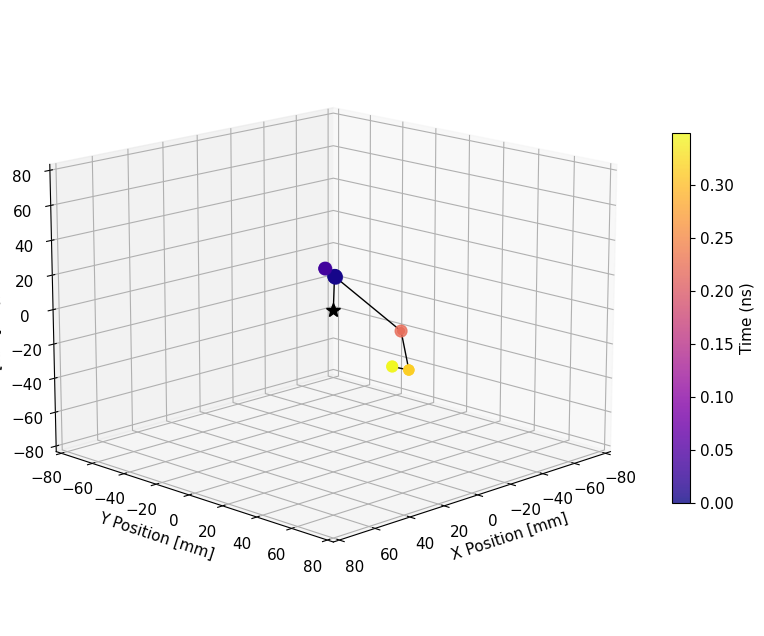

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

idx = 10

x = gammas_data['stepX'][idx]
y = gammas_data['stepY'][idx]
z = gammas_data['stepZ'][idx]
energy = gammas_data['stepEnergy_keV'][idx]
time = gammas_data['stepTime_ns'][idx]
srt = np.argsort(time)
print('Range of event {}: {:4.4}mm'.format(idx, ComputeRange(x[srt],y[srt],z[srt])))

marker_sizes = (energy - min(energy)) / (max(energy) - min(energy)) * 100
time_normalized = time - min(time) #(time - min(time)) / (max(time) - min(time)) * 200

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x[srt], y[srt], z[srt], s=marker_sizes[srt], c=time_normalized[srt], cmap='plasma', alpha=0.8)
p = ax.plot(np.append([0.],x[srt]), np.append([0.],y[srt]), np.append([0.],z[srt]), '-k', linewidth=1)
p2 = ax.plot(0.,0.,0.,'*',color='k',markersize=10)

box_size = 80.

ax.set_xlim(-box_size,box_size)
ax.set_ylim(-box_size,box_size)
ax.set_zlim(-box_size,box_size)
ax.view_init(elev=15, azim=45)

ax.set_xlabel("X Position [mm]")
ax.set_ylabel("Y Position [mm]")
ax.set_zlabel("Z Position [mm]")

cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Time (ns)")
plt.savefig('plots/gamma_evt_display_evt_{}_01.png'.format(idx),dpi=200,bbox_inches='tight')


1
Average distances to first scatter: 8.987 cm


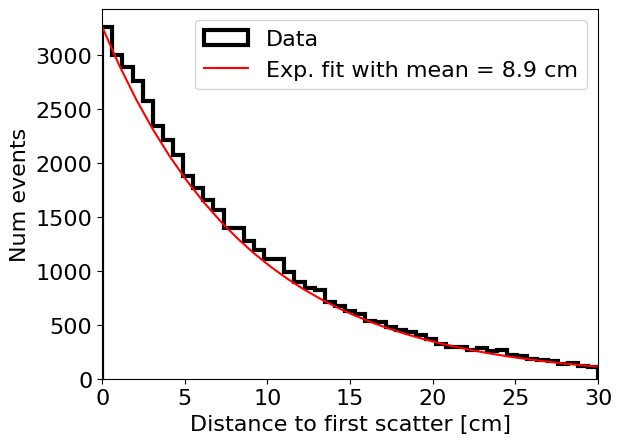

In [11]:
# Compute distribution of distances to first scatter:
distances = []
printed = False

plt.rcParams['font.size'] = 16

for idx in range(len(gammas_data['stepX'])):
    
    x = gammas_data['stepX'][idx]
    y = gammas_data['stepY'][idx]
    z = gammas_data['stepZ'][idx]
    energy = gammas_data['stepEnergy_keV'][idx]
    time = gammas_data['stepTime_ns'][idx]
    srt = np.argsort(time)
    
    d = np.sqrt( x[srt][0]**2 + y[srt][0]**2 + z[srt][0]**2 ) 
    
    
    if d > 120 and not printed:
        print(idx)
        printed=True
    
    distances.append( d )

    
distances = np.array(distances)

print('Average distances to first scatter: {:4.4} cm'.format(np.mean(distances)/10))

vals, bins, _x = plt.hist(distances/10., bins=np.linspace(0.,30.,50), histtype='step', color='k', linewidth=3, label='Data')
plt.xlim(0.,30.)
plt.xlabel('Distance to first scatter [cm]')
plt.ylabel('Num events')

xfit = np.linspace(0.,50.)
yfit = np.max(vals)*np.exp(-xfit/8.9)
plt.plot(xfit,yfit,'-r', label='Exp. fit with mean = 8.9 cm')
plt.legend()

plt.savefig('plots/gamma_distance_to_first_scatter.png', dpi=200, bbox_inches='tight')




In [12]:
def ClusteringSimple(data, evtidx, cluster_scale=10., doubleEvent = False):
    clusters = []
    
    scale = cluster_scale # units: mm
    
    # Clusters will be dicts with:
    #    - total energy
    #    - mean position
    #    - RMS position
    
    if not doubleEvent:
        x = data['stepX'][evtidx]
        y = data['stepY'][evtidx]
        z = data['stepZ'][evtidx]
        energy = data['stepEnergy_keV'][evtidx]
        time = data['stepTime_ns'][evtidx]
    else:
        x = np.append( data['stepX'][evtidx], data['stepX'][evtidx+1] )
        y = np.append( data['stepY'][evtidx], data['stepY'][evtidx+1] )
        z = np.append( data['stepZ'][evtidx], data['stepZ'][evtidx+1] )
        energy = np.append( data['stepEnergy_keV'][evtidx], data['stepEnergy_keV'][evtidx+1] )
        time = np.append( -data['stepTime_ns'][evtidx], data['stepTime_ns'][evtidx+1] )
    
    # Sorting by time doesn't quite work, since the electron tracks can happen essentially simultaneously (I guess)
    if doubleEvent:
        srtidx = np.argsort(time)
    else:
        srtidx = np.argsort(z)
    x = x[srtidx]
    y = y[srtidx]
    z = z[srtidx]
    energy = energy[srtidx]
    
    this_cluster = {}
    this_energy = [energy[0]]
    this_positions = [np.array([x[0],y[0],z[0]])]
    
    for i in range(1,len(x)):
        
        dist = np.sqrt( (x[i]-x[i-1])**2 + (y[i]-y[i-1])**2 + (z[i]-z[i-1])**2 )
        
        if dist < scale:
            # Add step "i" to the present cluster
            this_energy.append( energy[i] )
            this_positions.append( np.array([x[i], y[i], z[i]]) )
            
        else:
            # End this cluster, compute and store its relevant quantities, and then start a new
            # cluster with step "i"
            this_energy = np.array(this_energy)
            this_positions = np.array(this_positions)
            
            this_cluster['Energy'] = np.sum(this_energy)
            # this_cluster['Position'] = np.array( [ np.sum(this_energy*this_positions[:,0]), \
            #                                       np.sum(this_energy*this_positions[:,1]), \
            #                                       np.sum(this_energy*this_positions[:,2]) ]) / np.sum(this_energy)
            this_cluster['X'] = np.sum(this_energy*this_positions[:,0]) / np.sum(this_energy)
            this_cluster['Y'] = np.sum(this_energy*this_positions[:,1]) / np.sum(this_energy)
            this_cluster['Z'] = np.sum(this_energy*this_positions[:,2]) / np.sum(this_energy)
            this_cluster['Width'] = np.sqrt( np.sum( this_energy* ( (this_positions[:,0] - this_cluster['X'])**2 + \
                                                         (this_positions[:,1] - this_cluster['Y'])**2 + \
                                                        (this_positions[:,2] - this_cluster['Z'])**2 ) ) / np.sum(this_energy) )
            
            clusters.append(this_cluster)
            
            this_cluster = {}
            this_energy = [energy[i]]
            this_positions = [np.array([x[i],y[i],z[i]])]
            
    this_energy = np.array(this_energy)
    this_positions = np.array(this_positions)

    this_cluster['Energy'] = np.sum(this_energy)
    this_cluster['X'] = np.sum(this_energy*this_positions[:,0]) / np.sum(this_energy)
    this_cluster['Y'] = np.sum(this_energy*this_positions[:,1]) / np.sum(this_energy)
    this_cluster['Z'] = np.sum(this_energy*this_positions[:,2]) / np.sum(this_energy)
    # this_cluster['Position'] = np.array( [ np.sum(this_energy*this_positions[:,0]), \
    #                                       np.sum(this_energy*this_positions[:,1]), \
    #                                       np.sum(this_energy*this_positions[:,2]) ]) / np.sum(this_energy)
    this_cluster['Width'] = np.sqrt( np.sum( this_energy* ( (this_positions[:,0] - this_cluster['X'])**2 + \
                                                         (this_positions[:,1] - this_cluster['Y'])**2 + \
                                                        (this_positions[:,2] - this_cluster['Z'])**2 ) ) / np.sum(this_energy) )
    clusters.append(this_cluster)
            
    return pd.DataFrame(clusters)
            
#####################################################################################################################

from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

def ClusteringDBSCAN(data, evtidx, cluster_scale=1.5, min_samples=1, doubleEvent=False):
    if not doubleEvent:
        x = data['stepX'][evtidx]
        y = data['stepY'][evtidx]
        z = data['stepZ'][evtidx]
        energy = data['stepEnergy_keV'][evtidx]
    else:
        x = np.append(data['stepX'][evtidx], data['stepX'][evtidx+1])
        y = np.append(data['stepY'][evtidx], data['stepY'][evtidx+1])
        z = np.append(data['stepZ'][evtidx], data['stepZ'][evtidx+1])
        energy = np.append(data['stepEnergy_keV'][evtidx], data['stepEnergy_keV'][evtidx+1])

    points = np.vstack([x, y, z]).T
    labels = DBSCAN(eps=cluster_scale, min_samples=min_samples).fit_predict(points)

    clusters = []
    for lbl in np.unique(labels):
        mask = labels == lbl
        e = energy[mask]
        pos = points[mask]
        cluster = {
            "Energy": np.sum(e),
            "X": np.sum(e * pos[:,0]) / np.sum(e),
            "Y": np.sum(e * pos[:,1]) / np.sum(e),
            "Z": np.sum(e * pos[:,2]) / np.sum(e),
            "Width": np.sqrt(np.sum(e * np.sum((pos - pos.mean(axis=0))**2, axis=1)) / np.sum(e)),
        }
        clusters.append(cluster)

    return pd.DataFrame(clusters)


######################################################################################################
import uproot
import awkward as ak
import numpy as np
import pandas as pd

def dataframe_to_root(df: pd.DataFrame, filename: str, treename: str = "tree"):
    """
    Convert a pandas DataFrame with array-like columns into a ROOT file with C++ vectors.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame. Columns can be scalars or array-like (lists/numpy arrays).
    filename : str
        Name of the output ROOT file.
    treename : str
        Name of the TTree to be created.
    """

    awkward_arrays = {}
    for col in df.columns:
        coldata = df[col].to_numpy()

        # If entries are array-like, build an awkward array of variable-length lists
        if isinstance(coldata[0], (list, np.ndarray)):
            awkward_arrays[col] = ak.Array(coldata)
        else:
            awkward_arrays[col] = np.array(coldata)

    with uproot.recreate(filename) as fout:
        fout[treename] = awkward_arrays

    
#####################################################################################################    
    
import uproot
import awkward as ak
import numpy as np
import pandas as pd

def list_of_dfs_to_root(df_list: list[pd.DataFrame], filename: str, treename: str = "tree"):
    """
    Convert a list of per-event DataFrames into a ROOT TTree with vector branches.
    
    Parameters
    ----------
    df_list : list of pd.DataFrame
        Each DataFrame contains the data for one event.
        All DataFrames must have the same column structure.
    filename : str
        Output ROOT filename.
    treename : str
        Name of the TTree to be created.
    """

    if not df_list:
        raise ValueError("Input list of DataFrames is empty")

    # Initialize storage: one list per branch
    branch_data = {col: [] for col in df_list[0].columns}

    # Loop over events
    for df in df_list:
        for col in df.columns:
            values = df[col].to_numpy()

            # If this event has multiple rows → store as vector
            if len(values) > 1:
                branch_data[col].append(values)
            else:
                # Single value → store scalar
                branch_data[col].append(values[0])

    # Convert to awkward/numpy arrays
    awkward_arrays = {}
    for col, vals in branch_data.items():
        if isinstance(vals[0], (list, np.ndarray)):
            awkward_arrays[col] = ak.Array(vals)
        else:
            awkward_arrays[col] = np.array(vals)

    # Write to ROOT
    with uproot.recreate(filename) as fout:
        fout[treename] = awkward_arrays


In [13]:
# Test the clustering code

# clusters = ClusteringSimple(gammas_data, 13, cluster_scale = 1.5, doubleEvent=False)
clusters = ClusteringDBSCAN(gammas_data, 13, doubleEvent=False)

print('Number of clusters: {}'.format(len(clusters)))
# from tabulate import tabulate
pd.options.display.float_format = '{:>10.3f}'.format
# pd.options.display.column_space = 10
print(clusters.head(n=100))


# print('Distance between clusters:')
for i in range(len(clusters)-1):
    for j in range(i,len(clusters)):
        cluster1 = clusters.iloc[i]
        cluster2 = clusters.iloc[j]
        
        dist = np.sqrt( (cluster1['X']-cluster2['X'])**2 + (cluster1['Y']-cluster2['Y'])**2 + (cluster1['Z'] - cluster2['Z'])**2 )
        # print('\t{} & {}: {:4.4}'.format(i,j,dist))
    

Number of clusters: 3
      Energy          X          Y          Z      Width
0   1975.257     -1.306      9.988     -9.601      0.804
1     80.241      3.767      4.186    -17.662      0.004
2    392.201     23.592      2.167    -30.871      0.078


## Do some analysis of clusters in the 

In [14]:
def ReturnClusteredData( sigdata, bkgdata, cluster_scale = 1., num_evts=-1 ):

    # First, do a loop over signal events and count how many are "multi-site"
    num_sig_evts = num_evts*2
    
    if num_evts > 0:
        sig_evts = 2*num_evts
        bkg_evts = num_evts
    else:
        sig_evts = len(sigdata['stepX'])
        bkg_evts = len(bkgdata['stepX'])
        
    sig_clusters = []
    bkg_clusters = []
    
    for i in range(0,sig_evts-2,2):
        if i%1000==0: print('Running signal evt {}...'.format(i))
        sig_clusters.append( ClusteringDBSCAN(sigdata, i, cluster_scale = cluster_scale, doubleEvent=True) )
        # sig_clusters.append( ClusteringSimple(sigdata, i, cluster_scale = cluster_scale, doubleEvent=True) )
    
        
    for i in range(0,bkg_evts,1):
        if i%1000==0: print('Running bkg evt {}...'.format(i))
        bkg_clusters.append( ClusteringDBSCAN(bkgdata, i, cluster_scale = cluster_scale, doubleEvent=False) )
        # bkg_clusters.append( ClusteringSimple(bkgdata, i, cluster_scale = cluster_scale, doubleEvent=False) )
        
        
    return sig_clusters, bkg_clusters
    

In [3]:
# bkg_clusters
import pickle as pkl

WRITE_CLUSTERS = False

if WRITE_CLUSTERS:
    print('Clustering data and saving to file...')
    sig_clusters, bkg_clusters = ReturnClusteredData(electrons_data, gammas_data, cluster_scale =2.)

    with open('data/sig_clusters_5e4_DBSCAN_2.pkl','wb') as outfile:
            pkl.dump(sig_clusters,outfile)
    with open('data/bkg_clusters_5e4_DBSCAN_2.pkl','wb') as outfile:
            pkl.dump(bkg_clusters,outfile)
    print('Done.\n')
            
else:
    
    print('Reading pre-saved clustered data...')
    with open('data/sig_clusters_5e4_DBSCAN_2.pkl','rb') as infile:
            sig_clusters = pkl.load(infile)
    with open('data/bkg_clusters_5e4_DBSCAN_2.pkl','rb') as infile:
            bkg_clusters = pkl.load(infile)
    print('Done.\n')

Reading pre-saved clustered data...
Done.



In [4]:
WRITE_FILE_FOR_JINGKE = False

if WRITE_FILE_FOR_JINGKE:
    dataframe_to_root(sig_clusters, "sig_clusters.root", "clusters")

In [5]:
sig_clusters[3].head(n=100)

,Energy,X,Y,Z,Width
0,1771.708869,0.344158,0.165722,-0.369697,0.332333
1,58.162037,-12.321397,-32.436570,-13.894576,0.001780
2,383.251159,-13.799741,-37.906220,-13.941252,0.072084
3,243.877936,29.919697,-35.071981,-4.579821,0.397343


In [6]:
sig_multiplicity = []
sig_larger_cluster_energy = []
sig_smaller_cluster_energy = []
sig_fraction_in_largest_cluster = []
sig_3mm_cut = [] # returns True if there are any two clusters separated by more than 3mm in Z


for i, clusters in enumerate(sig_clusters):
    
    if i%10000==0:
        print('Runnig signal evt {}...'.format(i))
    
    sig_multiplicity.append(len(clusters))
    
    # Find the energy of the largest cluster
    max_idx = clusters['Energy'].idxmax()
    row_with_max_energy = clusters.loc[max_idx]
    max_energy = row_with_max_energy['Energy']
    sig_fraction_in_largest_cluster.append(max_energy/2447.7)
    
    # loop over clusters and see if any of them are separated by more than 3mm in the Z position:
    FAILING_3MM_Z_CUT = False
    z_values = clusters["Z"].to_numpy()
    # compute pairwise differences (absolute values)
    diffs = np.abs(z_values[:, None] - z_values)
    # check if any difference > 3
    if np.any(diffs > 3.0):
        FAILING_3MM_Z_CUT = True
        
    sig_3mm_cut.append(FAILING_3MM_Z_CUT)
    
    
    if len(clusters) == 2:
        if clusters['Energy'].iloc[0] > clusters['Energy'].iloc[1]:
            sig_larger_cluster_energy.append(clusters['Energy'].iloc[0])
            sig_smaller_cluster_energy.append(clusters['Energy'].iloc[1])
        else:
            sig_larger_cluster_energy.append(clusters['Energy'].iloc[1])
            sig_smaller_cluster_energy.append(clusters['Energy'].iloc[0])
    else:
        sig_larger_cluster_energy.append(-1.)
        sig_smaller_cluster_energy.append(-1.)
    

Runnig signal evt 0...
Runnig signal evt 10000...
Runnig signal evt 20000...
Runnig signal evt 30000...
Runnig signal evt 40000...


In [7]:
bkg_multiplicity = []
bkg_larger_cluster_energy = []
bkg_smaller_cluster_energy = []
bkg_fraction_in_largest_cluster = []
bkg_3mm_cut = []

for i, clusters in enumerate(bkg_clusters):
    
    if i%10000==0:
        print('Runnig bkg evt {}...'.format(i))
    
    bkg_multiplicity.append(len(clusters))
    
    # Find the energy of the largest cluster
    max_idx = clusters['Energy'].idxmax()
    row_with_max_energy = clusters.loc[max_idx]
    max_energy = row_with_max_energy['Energy']
    bkg_fraction_in_largest_cluster.append(max_energy/2447.7)
    
    # loop over clusters and see if any of them are separated by more than 3mm in the Z position:
    FAILING_3MM_Z_CUT = False
    z_values = clusters["Z"].to_numpy()
    # compute pairwise differences (absolute values)
    diffs = np.abs(z_values[:, None] - z_values)
    # check if any difference > 3
    if np.any(diffs > 3.0):
        FAILING_3MM_Z_CUT = True
        
    bkg_3mm_cut.append(FAILING_3MM_Z_CUT)
    
        
    if len(clusters) == 2:
        if clusters['Energy'].iloc[0] > clusters['Energy'].iloc[1]:
            bkg_larger_cluster_energy.append(clusters['Energy'].iloc[0])
            bkg_smaller_cluster_energy.append(clusters['Energy'].iloc[1])
        else:
            bkg_larger_cluster_energy.append(clusters['Energy'].iloc[1])
            bkg_smaller_cluster_energy.append(clusters['Energy'].iloc[0])
    else:
        bkg_larger_cluster_energy.append(-1.)
        bkg_smaller_cluster_energy.append(-1.)


Runnig bkg evt 0...
Runnig bkg evt 10000...
Runnig bkg evt 20000...
Runnig bkg evt 30000...
Runnig bkg evt 40000...


In [8]:
# How many events pass the 3mm z cut?
print('MS identified by Z cut (bkg): {:4.4}'.format(np.sum(bkg_3mm_cut)/len(bkg_3mm_cut)))
print('MS identified by Z cut (sig): {:4.4}'.format(np.sum(sig_3mm_cut)/len(sig_3mm_cut)))

sig_multiplicity = np.array( sig_multiplicity)
bkg_multiplicity = np.array( bkg_multiplicity)

sig_3mm_cut = np.array(sig_3mm_cut)
bkg_3mm_cut = np.array(bkg_3mm_cut)

MS identified by Z cut (bkg): 0.9285
MS identified by Z cut (sig): 0.161


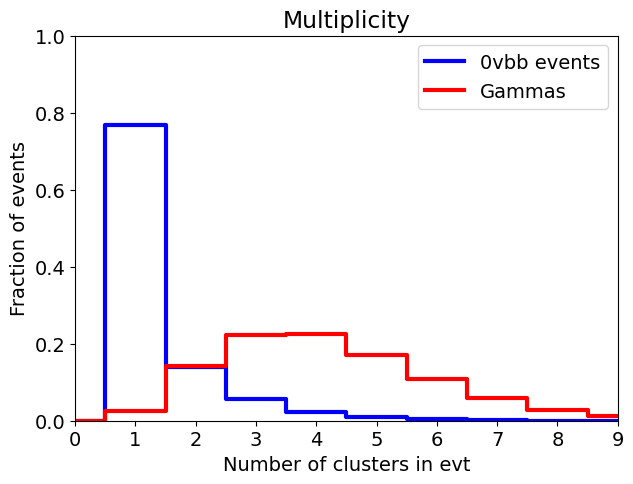

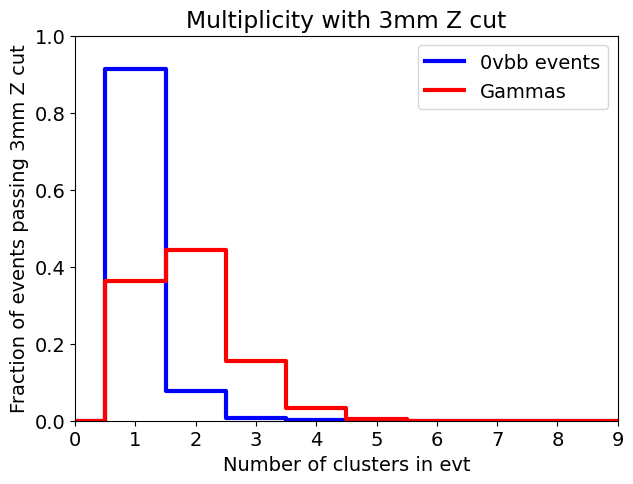

In [47]:
import histlite as hl
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size']=14

h1 = hl.hist(sig_multiplicity, bins=np.linspace(-0.5,9.5,11))

hl.plot1d(h1 / len(sig_multiplicity), linewidth=3, color='b', label='0vbb events')
plt.xlim(0.,9.)
plt.ylim(0.,1.)
plt.xlabel('Number of clusters in evt')
plt.ylabel('Fraction of events')
plt.title('Multiplicity')
# plt.yscale('log')

# plt.figure(2)

h1 = hl.hist(bkg_multiplicity, bins=np.linspace(-0.5,11.5,13))

hl.plot1d(h1 / len(bkg_multiplicity), linewidth=3, color='r', label='Gammas')
plt.legend()
# plt.xlim(0.,10.)
# plt.ylim(0.,1.)
# plt.xlabel('Number of clusters in evt')
# plt.ylabel('Fraction of events')
# plt.title('Multiplicity for bkg events')
# plt.yscale('log')
plt.savefig('plots/multiplicity_both_gammas_and_dbds.png',dpi=200,bbox_inches='tight')

plt.figure(2)

import histlite as hl
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size']=14

h1 = hl.hist(sig_multiplicity[np.invert(sig_3mm_cut)], bins=np.linspace(-0.5,9.5,11))

hl.plot1d(h1 / len(sig_multiplicity[np.invert(sig_3mm_cut)]), linewidth=3, color='b', label='0vbb events')
plt.xlim(0.,9.)
plt.ylim(0.,1.)
plt.xlabel('Number of clusters in evt')
plt.ylabel('Fraction of events passing 3mm Z cut')
plt.title('Multiplicity with 3mm Z cut')
# plt.yscale('log')

# plt.figure(2)

h1 = hl.hist(bkg_multiplicity[np.invert(bkg_3mm_cut)], bins=np.linspace(-0.5,11.5,13))

hl.plot1d(h1 / len(bkg_multiplicity[np.invert(bkg_3mm_cut)]), linewidth=3, color='r', label='Gammas')
plt.legend()
# plt.xlim(0.,10.)
# plt.ylim(0.,1.)
# plt.xlabel('Number of clusters in evt')
# plt.ylabel('Fraction of events')
# plt.title('Multiplicity for bkg events')
# plt.yscale('log')
plt.savefig('plots/multiplicity_both_gammas_and_dbds_3mm_Z_cut.png',dpi=200,bbox_inches='tight')



Text(0.5, 0, 'Energy of larger cluster [keV]')

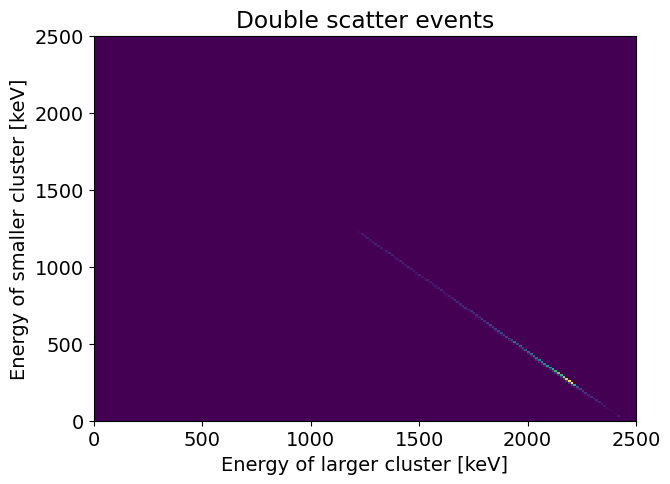

In [25]:
h2 = hl.hist([bkg_larger_cluster_energy, bkg_smaller_cluster_energy], bins=[np.linspace(0.,2500.,200),np.linspace(0.,2500.,200)])

hl.plot2d(h2)
# plt.
plt.title('Double scatter events')
plt.ylabel('Energy of smaller cluster [keV]')
plt.xlabel('Energy of larger cluster [keV]')

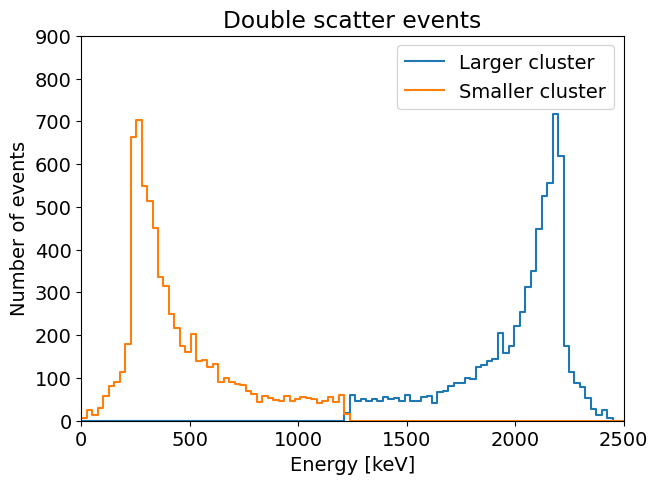

In [28]:
hlarger = hl.hist(bkg_larger_cluster_energy, bins=np.linspace(0.,2500.,100))
hsmaller = hl.hist(bkg_smaller_cluster_energy, bins=np.linspace(0.,2500.,100))

hl.plot1d(hlarger, label='Larger cluster')
hl.plot1d(hsmaller, label='Smaller cluster')

plt.xlim(0.,2500.)
plt.ylim(0.,900.)
plt.xlabel('Energy [keV]')
plt.ylabel('Number of events')
plt.title('Double scatter events')
plt.legend()

plt.savefig('plots/energy_partitioning_double_scatters.png',dpi=200,bbox_inches='tight')

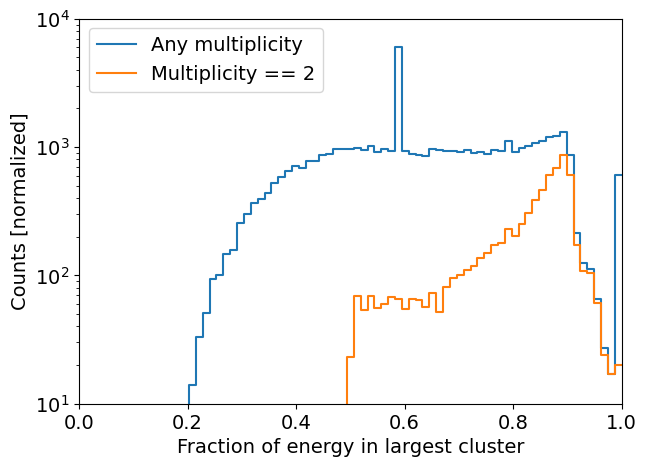

In [32]:
hfrac = hl.hist(bkg_fraction_in_largest_cluster, bins=np.linspace(0.,1.,80))
mask = np.array(bkg_larger_cluster_energy) > 0.
hfrac_double = hl.hist(np.array(bkg_fraction_in_largest_cluster)[mask], bins=np.linspace(0.,1.,80))


hl.plot1d(hfrac, label='Any multiplicity')
hl.plot1d(hfrac_double, label='Multiplicity == 2')
plt.xlabel('Fraction of energy in largest cluster')
plt.ylabel('Counts [normalized]')
plt.title('Fraction of energy in largest cluster (gammas)')
plt.xlim(0.,1.)
plt.ylim(0.,650.*5)
plt.legend()

plt.savefig('plots/energy_partitioning_all_multiplicities.png',dpi=200,bbox_inches='tight')

plt.xlabel('Fraction of energy in largest cluster')
plt.ylabel('Counts [normalized]')
plt.title('')
plt.xlim(0.,1.)
plt.ylim(10,1e4)
plt.legend()
plt.yscale('log')

plt.savefig('plots/energy_partitioning_all_multiplicities_log.png',dpi=200,bbox_inches='tight')



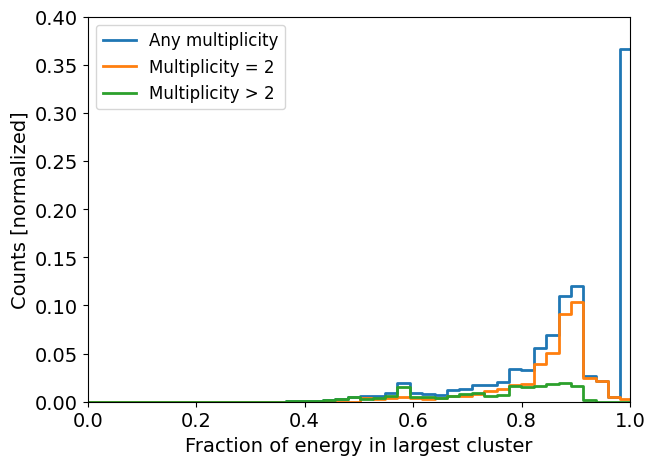

In [111]:
zcut = np.invert(bkg_3mm_cut)
bkg_mult_np = np.array(bkg_multiplicity)
bkg_fraction = np.array(bkg_fraction_in_largest_cluster)

bins = np.linspace(0.,1.005,45)

hfrac = hl.hist(bkg_fraction[zcut], bins=bins)
mask_double = bkg_mult_np == 2
hfrac_double = hl.hist(bkg_fraction[mask_double & zcut], bins=bins)
mask_multi = bkg_mult_np > 2.
hfrac_multi = hl.hist(bkg_fraction[mask_multi & zcut], bins=bins)

norm = np.sum(hfrac.values)

hl.plot1d(hfrac/norm, label='Any multiplicity',  linewidth=2)
hl.plot1d(hfrac_double/norm, label='Multiplicity = 2', linewidth=2)
hl.plot1d(hfrac_multi/norm, label='Multiplicity > 2', linewidth=2)

plt.xlabel('Fraction of energy in largest cluster')
plt.ylabel('Counts [normalized]')
# plt.title('Fraction of energy in largest cluster (gammas)')
plt.xlim(0.,1.0)
# plt.ylim(10.,2000)
# plt.yscale('log')

plt.ylim(0.,0.4)
plt.yscale('linear')

# plt.ylabel('Counts [normalized]')
# plt.title('')
# plt.xlim(0.,1.)
# plt.ylim(10,1e4)
# plt.legend()
# plt.yscale('log')

plt.legend(loc='upper left', fontsize=12)

plt.savefig('plots/energy_partitioning_all_multiplicities_with_3mm_Z_cut.png',dpi=200,bbox_inches='tight')

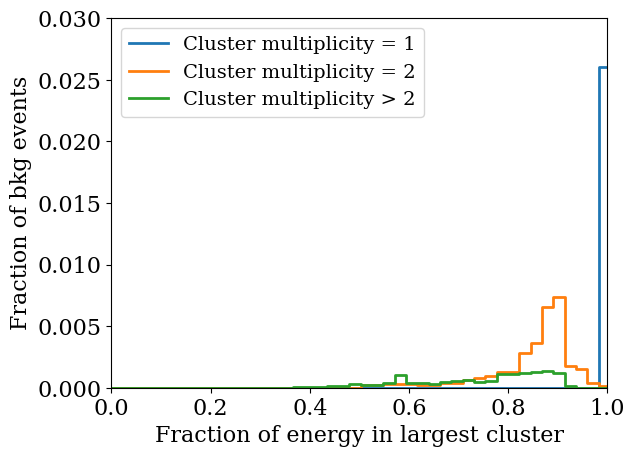

In [11]:
import histlite as hl  
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 16

zcut = np.invert(bkg_3mm_cut)
bkg_mult_np = np.array(bkg_multiplicity)
bkg_fraction = np.array(bkg_fraction_in_largest_cluster)

bins = np.linspace(0., 1.005, 45)

# Masks
mask_single = (bkg_mult_np == 1)
mask_double = (bkg_mult_np == 2)
mask_multi  = (bkg_mult_np >  2)


# Histograms
hfrac_single = hl.hist(bkg_fraction[mask_single & zcut], bins=bins)
hfrac_double = hl.hist(bkg_fraction[mask_double & zcut], bins=bins)
hfrac_multi  = hl.hist(bkg_fraction[mask_multi  & zcut], bins=bins)

# Normalization
norm = len(bkg_mult_np)

# Colors from the default color wheel
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Plot
hl.plot1d(hfrac_single/norm, label='Cluster multiplicity = 1', linewidth=2, color=colors[0])
hl.plot1d(hfrac_double/norm, label='Cluster multiplicity = 2', linewidth=2, color=colors[1])
hl.plot1d(hfrac_multi/norm,  label='Cluster multiplicity > 2', linewidth=2, color=colors[2])

plt.xlabel('Fraction of energy in largest cluster')
plt.ylabel('Fraction of bkg events')
plt.xlim(0., 1.0)
plt.ylim(0., 0.03)
plt.yscale('linear')

plt.legend(loc='upper left', fontsize=14)

plt.savefig(
    'plots/JINGKE_PAPER_energy_partitioning_all_multiplicities_with_3mm_Z_cut.pdf',
    bbox_inches='tight'
)
# plt.savefig('plots/JINGKE_PAPER_energy_partitioning_all_multiplicities_with_3mm_Z_cut.png',dpi=200,bbox_inches='tight')

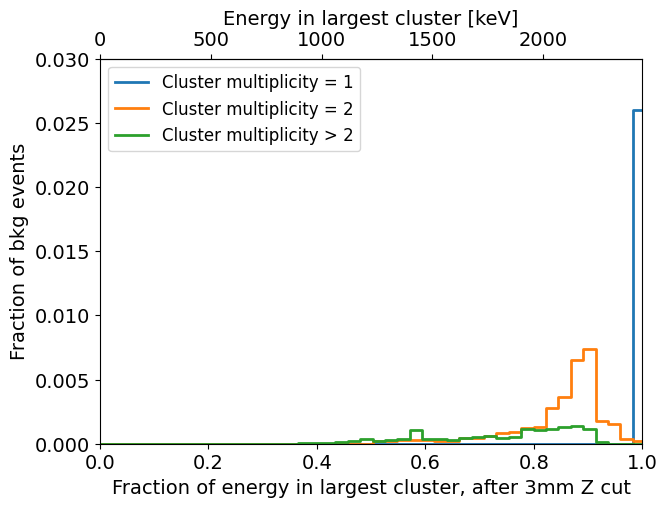

In [150]:

zcut = np.invert(bkg_3mm_cut)
bkg_mult_np = np.array(bkg_multiplicity)
bkg_fraction = np.array(bkg_fraction_in_largest_cluster)

bins = np.linspace(0., 1.005, 45)

# Masks
mask_single = (bkg_mult_np == 1)
mask_double = (bkg_mult_np == 2)
mask_multi  = (bkg_mult_np >  2)

# Histograms
hfrac_single = hl.hist(bkg_fraction[mask_single & zcut], bins=bins)
hfrac_double = hl.hist(bkg_fraction[mask_double & zcut], bins=bins)
hfrac_multi  = hl.hist(bkg_fraction[mask_multi  & zcut], bins=bins)

# Normalization
norm = len(bkg_mult_np)

# Colors from default wheel
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots()

# Plot
hl.plot1d(ax, hfrac_single/norm, label='Cluster multiplicity = 1', linewidth=2, color=colors[0])
hl.plot1d(ax, hfrac_double/norm, label='Cluster multiplicity = 2', linewidth=2, color=colors[1])
hl.plot1d(ax, hfrac_multi/norm,  label='Cluster multiplicity > 2', linewidth=2, color=colors[2])

# Axis labels
ax.set_xlabel('Fraction of energy in largest cluster, after 3mm Z cut')
ax.set_ylabel('Fraction of bkg events')
ax.set_xlim(0., 1.0)
ax.set_ylim(0., 0.03)
ax.set_yscale('linear')

# Secondary x-axis for energy
E0 = 2447.7  # keV

def frac_to_energy(x):
    return x * E0

def energy_to_frac(E):
    return E / E0

secax = ax.secondary_xaxis('top', functions=(frac_to_energy, energy_to_frac))
secax.set_xlabel('Energy in largest cluster [keV]')

# Legend
ax.legend(loc='upper left', fontsize=12)

plt.savefig(
    'plots/JINGKE_PAPER_energy_partitioning_all_multiplicities_with_3mm_Z_cut.png',
    dpi=200, bbox_inches='tight'
)

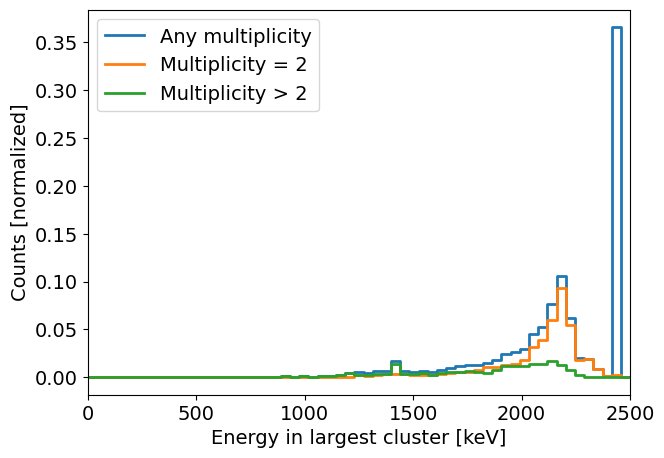

In [88]:
zcut = np.invert(bkg_3mm_cut)
bkg_mult_np = np.array(bkg_multiplicity)
bkg_fraction = np.array(bkg_fraction_in_largest_cluster)

E_gamma = 2447.7

hfrac = hl.hist(bkg_fraction[zcut]*E_gamma, bins=np.linspace(0.,2500.,60))
mask_double = bkg_mult_np == 2
hfrac_double = hl.hist(bkg_fraction[mask_double & zcut]*E_gamma, bins=np.linspace(0.,2500.,60))
mask_multi = bkg_mult_np > 2.
hfrac_multi = hl.hist(bkg_fraction[mask_multi & zcut]*E_gamma, bins=np.linspace(0.,2500.,60))

norm = np.sum(hfrac.values)

hl.plot1d(hfrac/norm, label='Any multiplicity',  linewidth=2)
hl.plot1d(hfrac_double/norm, label='Multiplicity = 2', linewidth=2)
hl.plot1d(hfrac_multi/norm, label='Multiplicity > 2', linewidth=2)

plt.xlabel('Energy in largest cluster [keV]')
plt.ylabel('Counts [normalized]')
# plt.title('Fraction of energy in largest cluster (gammas)')
plt.xlim(0.,2500.)
# plt.ylim(0.,1400)
# plt.yscale('log')

# plt.ylabel('Counts [normalized]')
# plt.title('')
# plt.xlim(0.,1.)
# plt.ylim(10,1e4)
# plt.legend()
# plt.yscale('log')

plt.legend()

plt.savefig('plots/energy_spectrum_all_multiplicities_with_3mm_Z_cut.png',dpi=200,bbox_inches='tight')

### Looking at spatial extent of events by multiplicity

In [ ]:
bkg_cluster_max_distance = []


for i, clusters in enumerate(bkg_clusters):
    
    max_dist = -1.
    
    for j in range(len(clusters)-1):
        for k in range(j,len(clusters)):
            cluster1 = clusters.iloc[j]
            cluster2 = clusters.iloc[k]
            
            dist = np.sqrt( (cluster1['X']-cluster2['X'])**2 + (cluster1['Y']-cluster2['Y'])**2 + (cluster1['Z'] - cluster2['Z'])**2 )
            # print('\t{} & {}: {:4.4}'.format(i,j,dist))
            if dist > max_dist: max_dist = dist
            
    bkg_cluster_max_distance.append(max_dist)
    


In [ ]:
hists = {}

hists['Total'] = hl.hist(bkg_cluster_max_distance, bins=np.linspace(0.,100.,50))

# create individual histograms for each integer value of bkg multiplicity
for i in range(10):
    mask = np.array(bkg_multiplicity) == i
    hist_label = 'Multiplicity == {}'.format(i)
    hists[hist_label] = hl.hist(np.array(bkg_cluster_max_distance)[mask], bins=np.linspace(0.,100.,50))
    



/var/tmp/lenardo1/ipykernel_2351506/2244553990.py:38: RuntimeWarning: invalid value encountered in scalar divide
  cumulative_fraction.append( np.sum(vals_2[:i+1]) / np.sum(vals_tot[0:i+1]) )


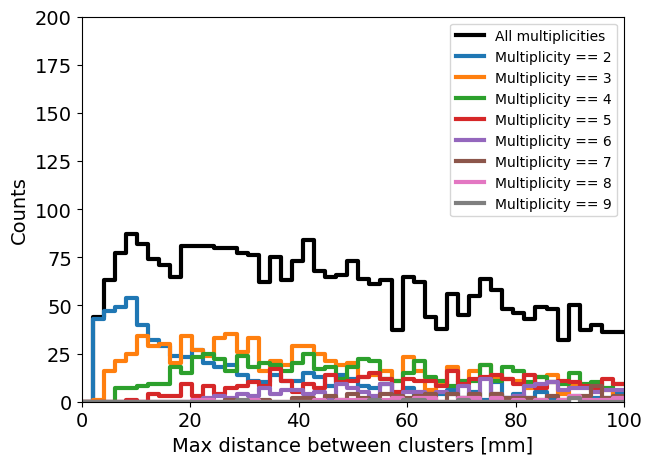

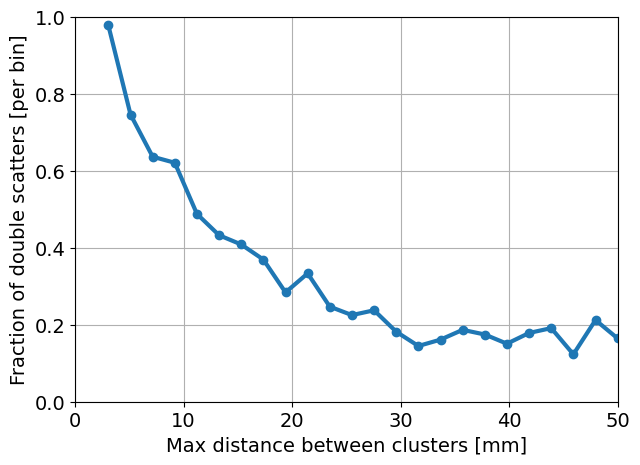

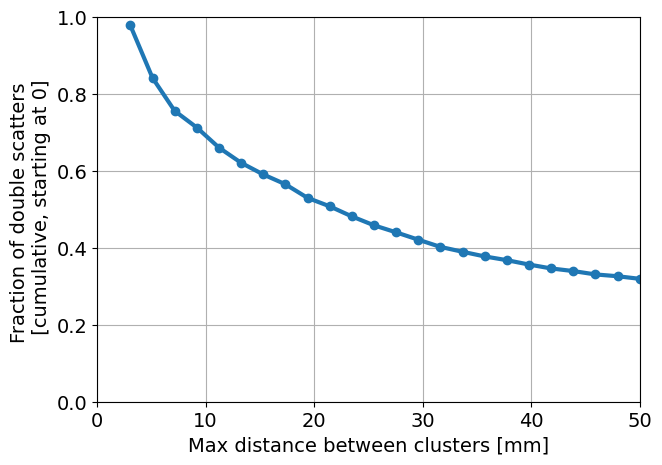

In [ ]:


plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size']=14
hl.plot1d(hists['Total'], linewidth=3, color='k', label='All multiplicities')
for i in range(2,10):
    hist_label = 'Multiplicity == {}'.format(i)
    hl.plot1d(hists[hist_label], label=hist_label, linewidth=3)
    
plt.xlabel('Max distance between clusters [mm]')
plt.ylabel('Counts')
plt.legend(fontsize=10)

plt.xlim(0.,100.)
plt.ylim(0.,200.)

plt.figure(2)

bins = hists['Multiplicity == 0'].bins[0]
vals_tot = hists['Total'].values
vals_2 = hists['Multiplicity == 2'].values
bin_centers = (bins[1:] + bins[:-1])/2.

h_frac = hists['Multiplicity == 2']/hists['Total']
plt.plot(bin_centers, h_frac.values, '-o', linewidth=3)
plt.xlabel('Max distance between clusters [mm]')
plt.ylabel('Fraction of double scatters [per bin]')

plt.xlim(0.,50.)
plt.ylim(0.,1.)
plt.grid()


plt.figure(3)

cumulative_fraction = []


for i in range(len(bin_centers)-1):
    cumulative_fraction.append( np.sum(vals_2[:i+1]) / np.sum(vals_tot[0:i+1]) )
    
plt.plot(bin_centers[:-1], np.array(cumulative_fraction), '-o', linewidth=3)

# hl.plot1d(hists['Multiplicity == 2']/hists['Total'], linewidth=3)
plt.xlabel('Max distance between clusters [mm]')
plt.ylabel('Fraction of double scatters \n [cumulative, starting at 0]')




plt.xlim(0.,50.)
plt.ylim(0.,1.)
plt.grid()

AxesSubplot(0.125,0.11;0.227941x0.77)


/var/tmp/lenardo1/ipykernel_2351506/1737154311.py:42: RuntimeWarning: invalid value encountered in scalar divide
  cumulative_fraction.append(np.sum(vals_2[:i+1]) / np.sum(vals_tot[:i+1]))


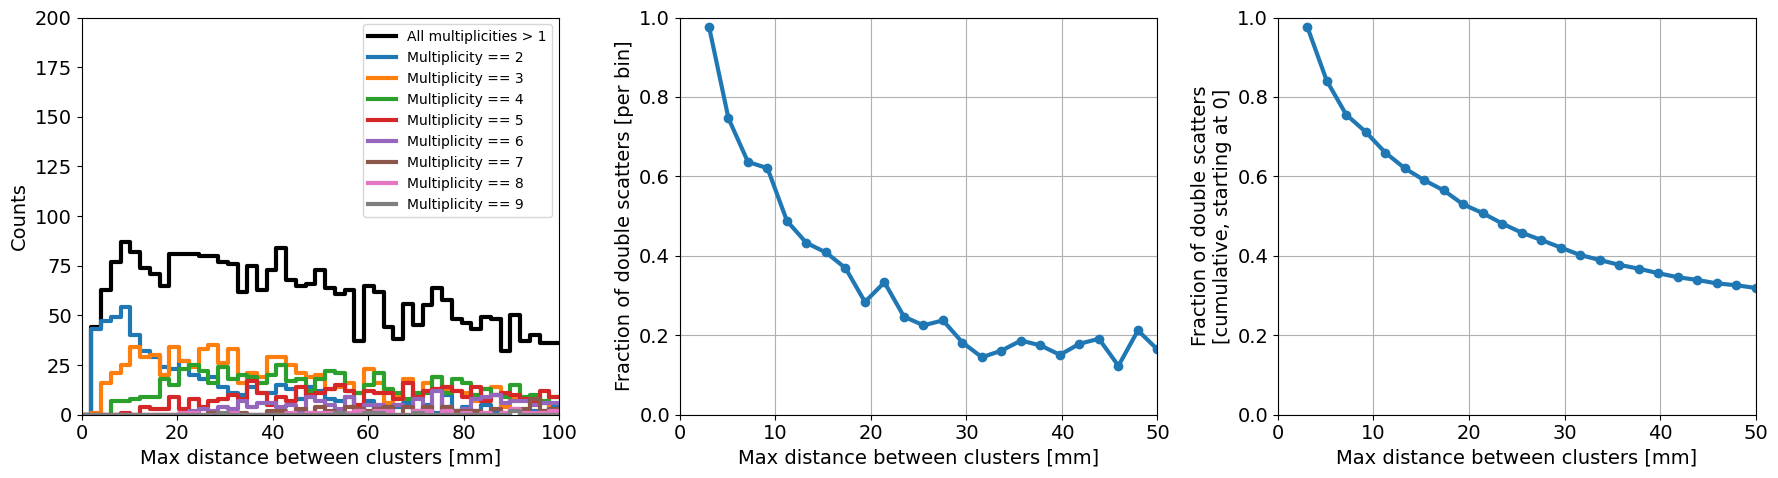

In [ ]:
# Set global style
plt.rcParams['figure.figsize'] = (18, 5)  # wider for 3 panels side by side
plt.rcParams['font.size'] = 14


# Create a single figure with 3 panels
fig, axes = plt.subplots(1, 3)

# --- Panel 1 ---
ax = axes[0]
print(ax)
hl.plot1d(ax, hists['Total'], linewidth=3, color='k', label='All multiplicities > 1')
for i in range(2, 10):
    hist_label = f'Multiplicity == {i}'
    hl.plot1d(ax, hists[hist_label], label=hist_label, linewidth=3)

ax.set_xlabel('Max distance between clusters [mm]')
ax.set_ylabel('Counts')
ax.legend(fontsize=10)
ax.set_xlim(0., 100.)
ax.set_ylim(0., 200.)

# --- Panel 2 ---
ax = axes[1]
bins = hists['Multiplicity == 0'].bins[0]
vals_tot = hists['Total'].values
vals_2 = hists['Multiplicity == 2'].values
bin_centers = (bins[1:] + bins[:-1]) / 2.

h_frac = hists['Multiplicity == 2'] / hists['Total']
ax.plot(bin_centers, h_frac.values, '-o', linewidth=3)
ax.set_xlabel('Max distance between clusters [mm]')
ax.set_ylabel('Fraction of double scatters [per bin]')
ax.set_xlim(0., 50.)
ax.set_ylim(0., 1.)
ax.grid()

# --- Panel 3 ---
ax = axes[2]
cumulative_fraction = []
for i in range(len(bin_centers)-1):
    cumulative_fraction.append(np.sum(vals_2[:i+1]) / np.sum(vals_tot[:i+1]))

ax.plot(bin_centers[:-1], cumulative_fraction, '-o', linewidth=3)
ax.set_xlabel('Max distance between clusters [mm]')
ax.set_ylabel('Fraction of double scatters\n[cumulative, starting at 0]')
ax.set_xlim(0., 50.)
ax.set_ylim(0., 1.)
ax.grid()

plt.tight_layout()

### 

# Compute spatial separation parameters

In [ ]:
def ComputeSigandBkgEff( sigdata, bkgdata, zres = 3., xyres = 1000., cluster_scale = 2., num_evts=-1 ):
    
    sig_assignments = [] # true if single-site, false if multi-site
    bkg_assignments = []
    
    # First, do a loop over signal events and count how many are "multi-site"
    num_sig_evts = num_evts*2
    
    if num_evts > 0:
        sig_evts = 2*num_evts
        bkg_evts = num_evts
    else:
        sig_evts = len(sigdata['stepX'])
        bkg_evts = len(bkgdata['stepX'])
    
    for i in range(0,sig_evts,2):
        # if i%200==0: print('Running signal evt {}...'.format(i))
        clusters = ClusteringDBSCAN(sigdata, i, cluster_scale = cluster_scale, doubleEvent=True)
        
        temp_assignment = True   # true if SS, false if MS
        
        for j in range(len(clusters)):
            for k in range(j+1,len(clusters)):
                # print('{}, {}'.format(j,k))
                cluster1 = clusters.iloc[j]
                cluster2 = clusters.iloc[k]
                
                
                if np.sqrt((cluster1['Z'] - cluster2['Z'])**2) > zres or\
                        np.sqrt( (cluster1['X']-cluster2['X'])**2 + (cluster1['Y']-cluster2['Y'])**2) > xyres:
                    temp_assignment=False
                    break
                    
        sig_assignments.append(temp_assignment)
        

        
    for i in range(0,bkg_evts,1):
        # if i%200==0: print('Running bkg evt {}...'.format(i))
        clusters = ClusteringDBSCAN(bkgdata, i, cluster_scale = cluster_scale, doubleEvent=False)
        temp_assignment = True
        for j in range(len(clusters)):
            for k in range(j+1,len(clusters)):
                cluster1 = clusters.iloc[j]
                cluster2 = clusters.iloc[k]
                
                if np.sqrt((cluster1['Z'] - cluster2['Z'])**2) > zres or\
                        np.sqrt( (cluster1['X']-cluster2['X'])**2 + (cluster1['Y']-cluster2['Y'])**2) > xyres:
                    temp_assignment=False
                    break
                    
        bkg_assignments.append(temp_assignment)
        
        
    return np.array(sig_assignments), np.array(bkg_assignments)
    
    

In [ ]:
# Plot sig and bkg eff vs. cluster scale, given z=3mm and xy=inf
cluster_scale = np.linspace(0.5,2.,10)
sig_eff = []
bkg_eff = []


for i, cs in enumerate(cluster_scale):
    print('Cluster scale: {:4.4} mm'.format(cs))
    
    sig, bkg = ComputeSigandBkgEff(electrons_data,gammas_data,cluster_scale=cs,num_evts=400)
    
    sig_eff.append(np.sum(sig)/len(sig))
    bkg_eff.append(np.sum(bkg)/len(bkg))
    
sig_eff = np.array(sig_eff)
bkg_eff = np.array(bkg_eff)



Cluster scale:  0.5 mm
Cluster scale: 0.6667 mm
Cluster scale: 0.8333 mm
Cluster scale:  1.0 mm
Cluster scale: 1.167 mm
Cluster scale: 1.333 mm
Cluster scale:  1.5 mm
Cluster scale: 1.667 mm
Cluster scale: 1.833 mm
Cluster scale:  2.0 mm


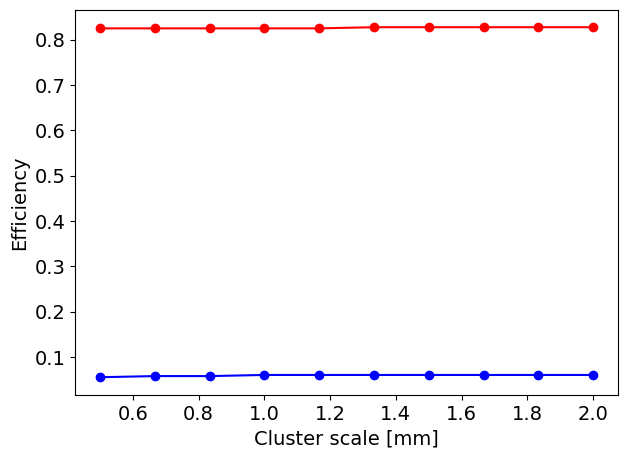

<Figure size 700x500 with 0 Axes>

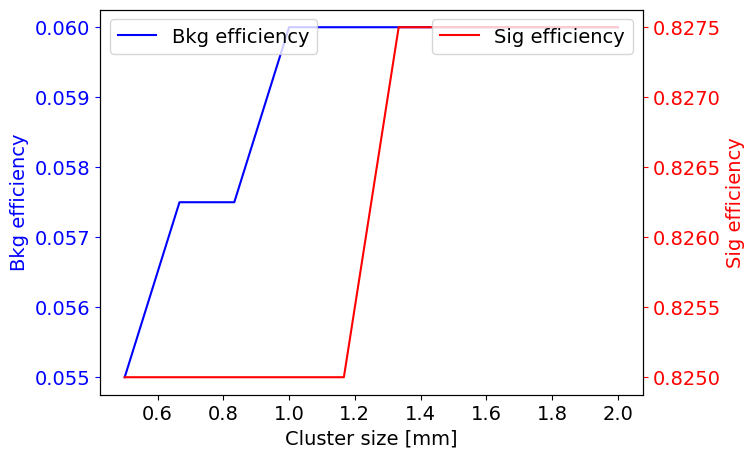

In [ ]:
plt.plot(cluster_scale, sig_eff, '-or')
plt.plot(cluster_scale, bkg_eff, '-ob')

plt.xlabel('Cluster scale [mm]')
plt.ylabel('Efficiency')




plt.figure(2)
fig, ax1 = plt.subplots()

# Left axis (y1)
ax1.plot(cluster_scale, bkg_eff, 'b-', label="Bkg efficiency")
ax1.set_xlabel("Cluster size [mm]", color="black")
ax1.set_ylabel("Bkg efficiency", color="blue")
ax1.tick_params(axis='y', colors='blue')
ax1.legend(loc="upper left")

# Right axis (y2)
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(cluster_scale, sig_eff, 'r-', label="Sig efficiency")
ax2.set_ylabel("Sig efficiency", color="red")
ax2.tick_params(axis='y', colors='red')
ax2.legend(loc="upper right")

In [ ]:
import os
import pickle as pkl

zres = np.linspace(1.,8.,15)
num_evts = 2000
RERUN=False

if RERUN or 'zres_Yvals_sigeff.pkl' not in os.listdir('./data/'):
    # Plot sig and bkg eff vs. z, given cluster_scale=1., and xy=inf

    sig_eff = []
    bkg_eff = []


    for i, this_zres in enumerate(zres):
        print('zres: {:4.4} mm'.format(this_zres))

        sig, bkg = ComputeSigandBkgEff(electrons_data,gammas_data,zres=this_zres,num_evts=num_evts)

        sig_eff.append(np.sum(sig)/len(sig))
        bkg_eff.append(np.sum(bkg)/len(bkg))

    sig_eff = np.array(sig_eff)
    bkg_eff = np.array(bkg_eff)

    with open('data/zres_Xvals_mm.pkl','wb') as outfile:
        pkl.dump(zres,outfile)
    with open('data/zres_Yvals_sigeff.pkl','wb') as outfile:
        pkl.dump(sig_eff,outfile)
    with open('data/zres_Yvals_bkgeff.pkl','wb') as outfile:
        pkl.dump(bkg_eff,outfile)
else:
    print('Loading data from existing files...')
    with open('data/zres_Xvals_mm.pkl','rb') as infile:
        zres = pkl.load(infile)
    with open('data/zres_Yvals_sigeff.pkl','rb') as infile:
        sig_eff = pkl.load(infile)
    with open('data/zres_Yvals_bkgeff.pkl','rb') as infile:
        bkg_eff = pkl.load(infile)
        
print('Done.')



Loading data from existing files...
Done.


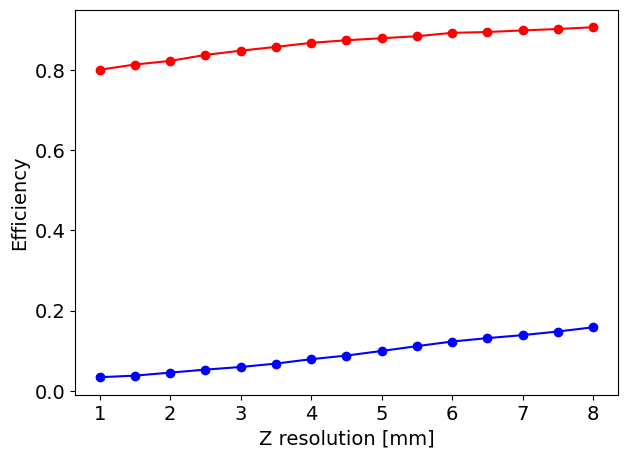

<Figure size 700x500 with 0 Axes>

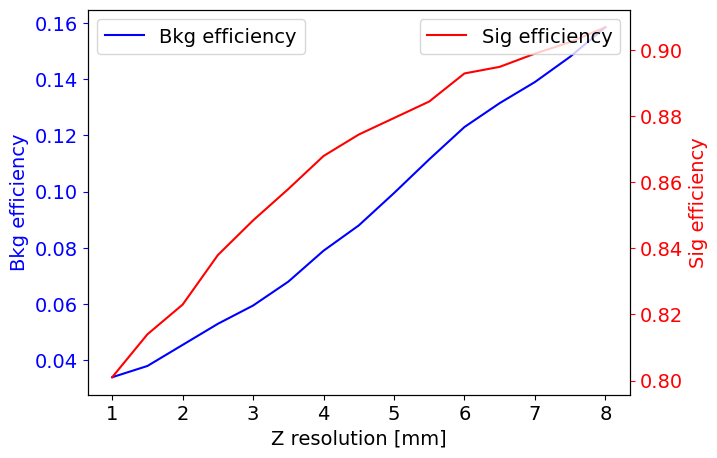

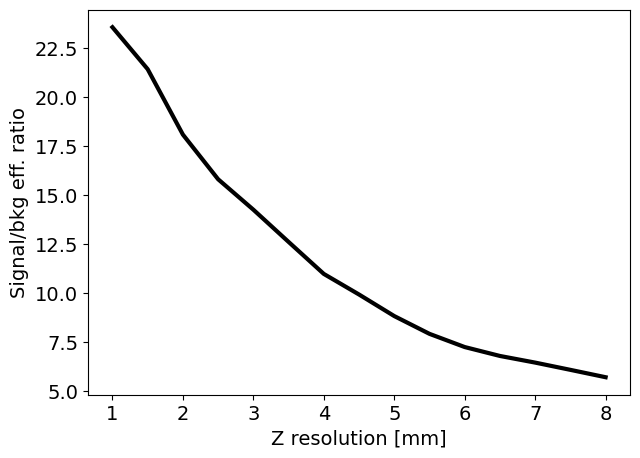

In [ ]:
plt.plot(zres, sig_eff, '-or')
plt.plot(zres, bkg_eff, '-ob')

plt.xlabel('Z resolution [mm]')
plt.ylabel('Efficiency')

plt.savefig('plots/zres_general_plot.png',dpi=200,bbox_inches='tight')


plt.figure(2)
fig, ax1 = plt.subplots()

# Left axis (y1)
ax1.plot(zres, bkg_eff, 'b-', label="Bkg efficiency")
ax1.set_xlabel("Z resolution [mm]", color="black")
ax1.set_ylabel("Bkg efficiency", color="blue")
ax1.tick_params(axis='y', colors='blue')
ax1.legend(loc="upper left")

# Right axis (y2)
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(zres, sig_eff, 'r-', label="Sig efficiency")
ax2.set_ylabel("Sig efficiency", color="red")
ax2.tick_params(axis='y', colors='red')
ax2.legend(loc="upper right")
            
plt.savefig('plots/zres_dual_axis_plot.png',dpi=200,bbox_inches='tight')


plt.figure(4)
plt.plot(zres, sig_eff/bkg_eff, '-k', linewidth=3, label='Signal/bkg ratio')
plt.xlabel('Z resolution [mm]')
plt.ylabel('Signal/bkg eff. ratio')
            
plt.savefig('plots/zres_signal_bkg_eff_ratio.png',dpi=200,bbox_inches='tight')


In [ ]:
# Plot sig and bkg eff vs. xyres, given cluster_scale=1., and z = 3

RERUN=False

xy_resolutions = np.linspace(2.,18.,20)
xy_resolutions = np.append(xy_resolutions, np.linspace(20,80.,7))
xy_resolutions = np.append(xy_resolutions, 100.)

z_resolutions = [2., 3., 4., 5.]


if RERUN or 'xyres_Xvals_mm_zres_2mm.pkl' not in os.listdir('./data/'):

    for j, this_zres in enumerate(z_resolutions):
        
        print('zres: {:4.4} mm ({} of {})'.format(this_zres,j,len(z_resolutions)))
        sig_eff = []
        bkg_eff = []

        import time
        start = time.time()

        for i, this_xyres in enumerate(xy_resolutions):

            print('\txyres: {:4.4} mm ({} of {}) at {:3.3} min'.format(this_xyres,i, len(xy_resolutions), (time.time()-start)/60.))

            sig, bkg = ComputeSigandBkgEff(electrons_data, gammas_data, zres=this_zres, xyres=this_xyres, num_evts=5000)

            sig_eff.append(np.sum(sig)/len(sig))
            bkg_eff.append(np.sum(bkg)/len(bkg))

        sig_eff = np.array(sig_eff)
        bkg_eff = np.array(bkg_eff)

        with open('data/xyres_Xvals_mm_zres_{}mm.pkl'.format(int(this_zres)),'wb') as outfile:
            pkl.dump(xy_resolutions,outfile)
        with open('data/zres_Yvals_sigeff_zres_{}mm.pkl'.format(int(this_zres)),'wb') as outfile:
            pkl.dump(sig_eff,outfile)
        with open('data/zres_Yvals_bkgeff_zres_{}mm.pkl'.format(int(this_zres)),'wb') as outfile:
            pkl.dump(bkg_eff,outfile)
            
else:
    print('Opening from files...')
    xyres_list = []
    for j, this_zres in enumerate(z_resolutions):    
        with open('data/xyres_Xvals_mm_zres_{}mm.pkl'.format(int(this_zres)),'rb') as infile:
            print('\tOpening {}'.format(infile.name))
            xyres = pkl.load(infile)
        with open('data/zres_Yvals_sigeff_zres_{}mm.pkl'.format(int(this_zres)),'rb') as infile:
            sig_eff = pkl.load(infile)
        with open('data/zres_Yvals_bkgeff_zres_{}mm.pkl'.format(int(this_zres)),'rb') as infile:
            bkg_eff = pkl.load(infile)
            
        this_dict = {'xyres':xyres, 'sig_eff':sig_eff, 'bkg_eff':bkg_eff}
        xyres_list.append(this_dict)
        
    print('Opened {} files'.format( len(xyres_list)))
            
    

Opening from files...
	Opening data/xyres_Xvals_mm_zres_2mm.pkl
	Opening data/xyres_Xvals_mm_zres_3mm.pkl
	Opening data/xyres_Xvals_mm_zres_4mm.pkl
	Opening data/xyres_Xvals_mm_zres_5mm.pkl
Opened 4 files


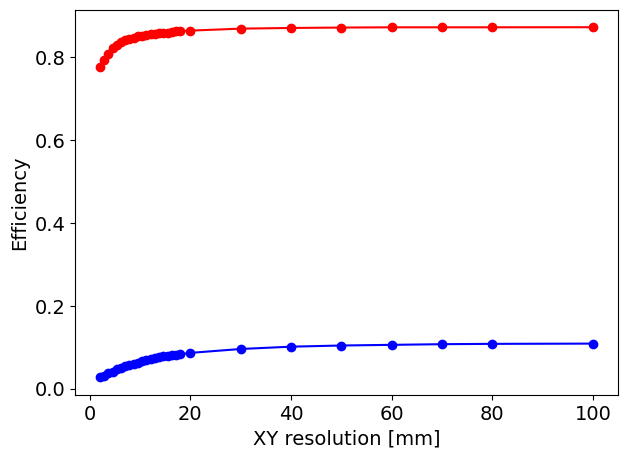

<Figure size 700x500 with 0 Axes>

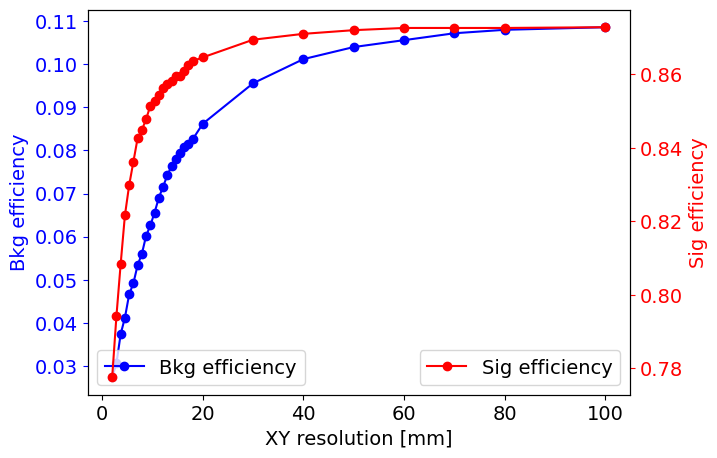

<Figure size 700x500 with 0 Axes>

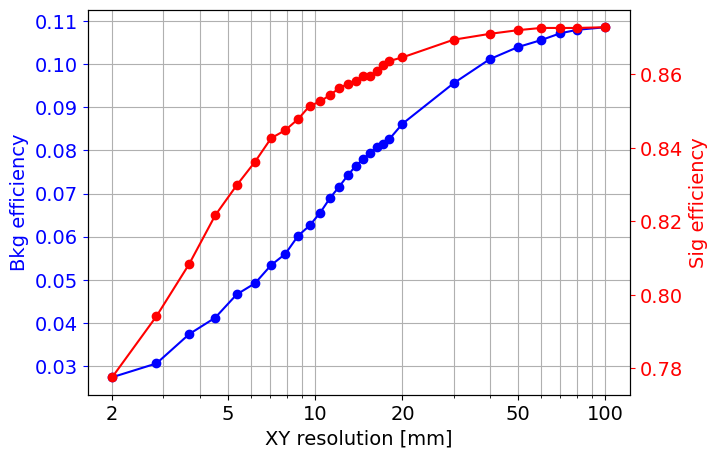

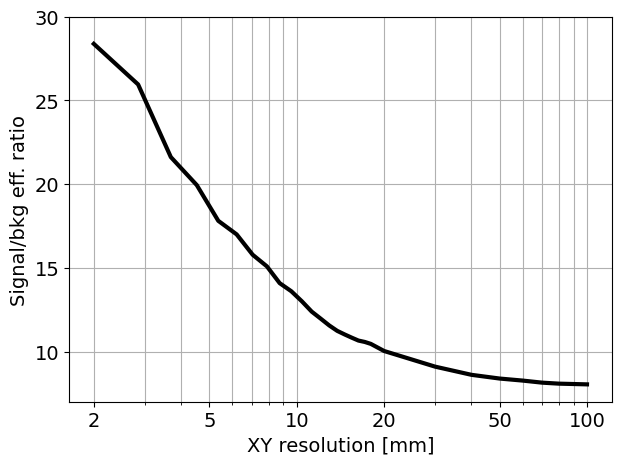

In [ ]:
xyres = xy_resolutions
plt.plot(xyres, sig_eff, '-or')
plt.plot(xyres, bkg_eff, '-ob')

plt.xlabel('XY resolution [mm]')
plt.ylabel('Efficiency')


plt.figure(2)
fig, ax1 = plt.subplots()

# Left axis (y1)
ax1.plot(xyres, bkg_eff, 'b-o', label="Bkg efficiency")
ax1.set_xlabel("XY resolution [mm]", color="black")
ax1.set_ylabel("Bkg efficiency", color="blue")
ax1.tick_params(axis='y', colors='blue')
ax1.legend(loc="lower left")

# Right axis (y2)
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(xyres, sig_eff, 'r-o', label="Sig efficiency")
ax2.set_ylabel("Sig efficiency", color="red")
ax2.tick_params(axis='y', colors='red')
ax2.legend(loc="lower right")
# plt.xscale('log')

plt.figure(5)
fig, ax1 = plt.subplots()

# Left axis (y1)
ax1.plot(xyres, bkg_eff, 'b-o', label="Bkg efficiency")
ax1.set_xlabel("XY resolution [mm]", color="black")
ax1.set_ylabel("Bkg efficiency", color="blue")
ax1.tick_params(axis='y', colors='blue')
# ax1.legend(loc="lower right")

# Right axis (y2)
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(xyres, sig_eff, 'r-o', label="Sig efficiency")
ax2.set_ylabel("Sig efficiency", color="red")
ax2.tick_params(axis='y', colors='red')
# ax2.legend(loc="lower right")
plt.xscale('log')
ax1.grid(which='both')
ax1.set_xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])

plt.figure(4)
plt.plot(xyres, sig_eff/bkg_eff, '-k', linewidth=3, label='Signal/bkg ratio')
plt.xlabel('XY resolution [mm]')
plt.ylabel('Signal/bkg eff. ratio')
plt.ylim(7.,30.)
plt.xscale('log')
plt.xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])
plt.grid(which='both')

<Figure size 700x500 with 0 Axes>

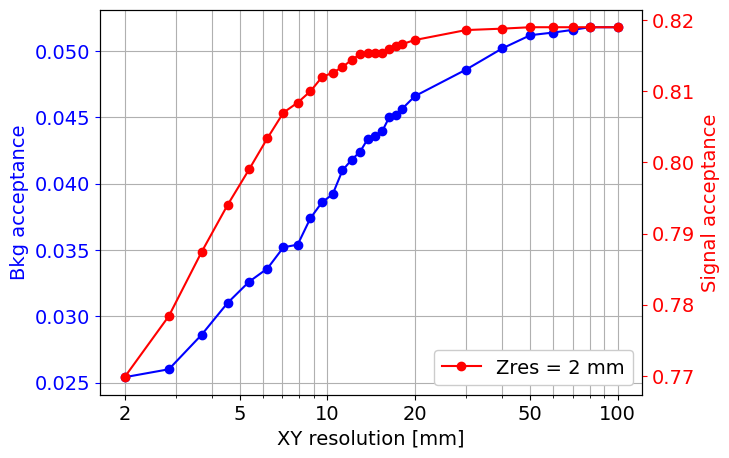

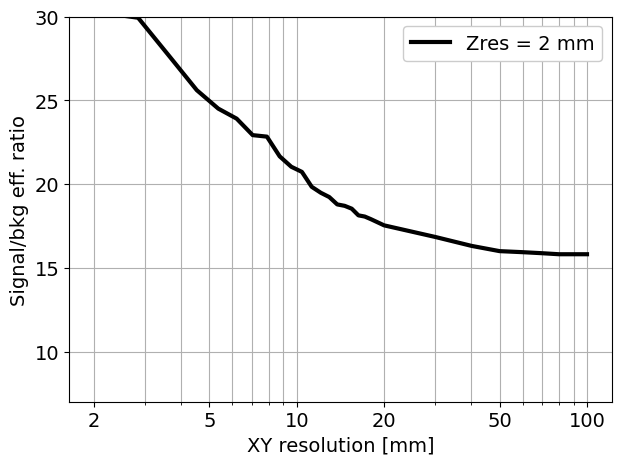

<Figure size 700x500 with 0 Axes>

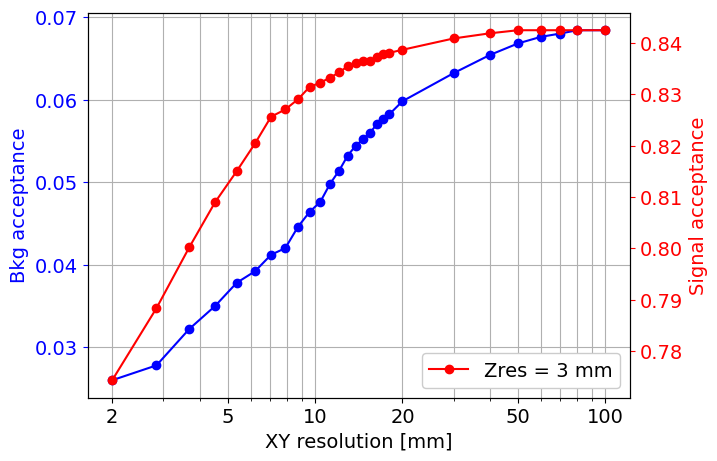

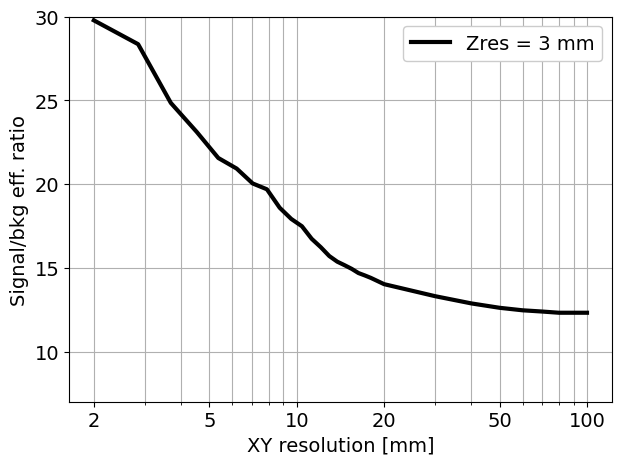

<Figure size 700x500 with 0 Axes>

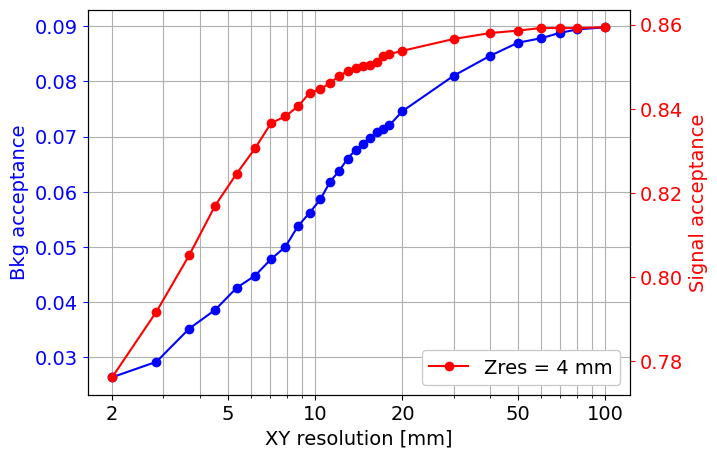

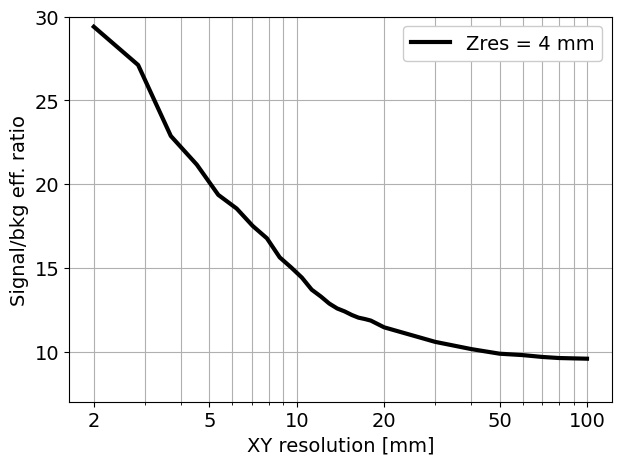

<Figure size 700x500 with 0 Axes>

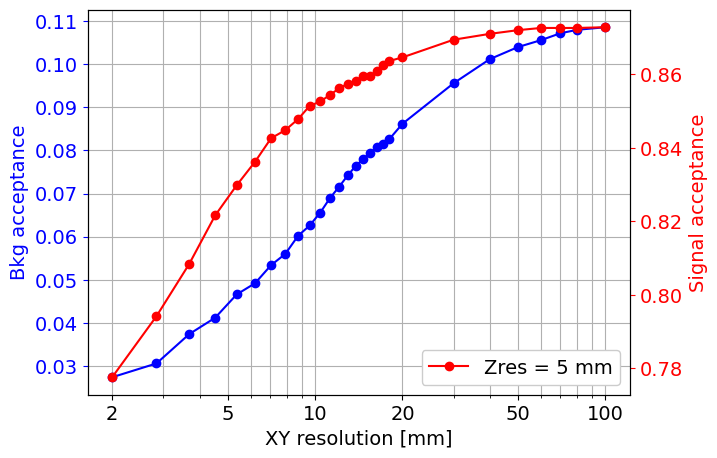

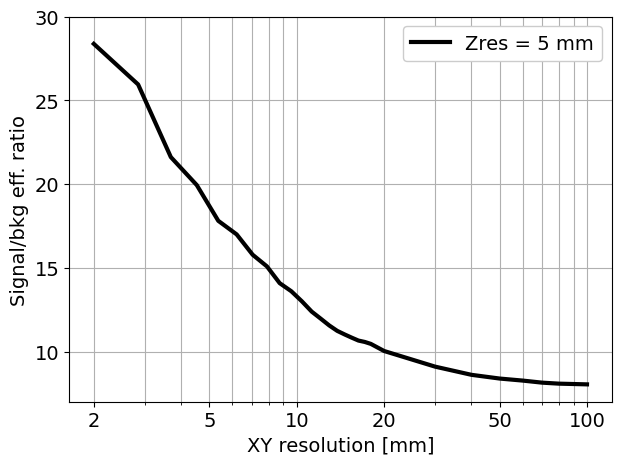

In [ ]:
for i, zres in enumerate(z_resolutions):
    
    plt.figure(3*i)
    fig, ax1 = plt.subplots()

    xyres = xyres_list[i]['xyres']
    bkg_eff = xyres_list[i]['bkg_eff']
    sig_eff = xyres_list[i]['sig_eff']
    
    
    # Left axis (y1)
    ax1.plot(xyres, bkg_eff, 'b-o', label="Bkg efficiency")
    ax1.set_xlabel("XY resolution [mm]", color="black")
    ax1.set_ylabel("Bkg acceptance", color="blue")
    ax1.tick_params(axis='y', colors='blue')
    # ax1.legend(loc="lower right")


    # Right axis (y2)
    ax2 = ax1.twinx()  # Create a second y-axis
    ax2.plot(xyres, sig_eff, 'r-o', label="Zres = {} mm".format(int(zres)))
    ax2.set_ylabel("Signal acceptance", color="red")
    ax2.tick_params(axis='y', colors='red')
    ax2.legend(loc="lower right",framealpha=1.)
    plt.xscale('log')
    ax1.grid(which='both')
    ax1.set_xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])

    if i == 1:
        plt.savefig('plots/efficiency_curves_zres_3mm_clustersize_1mm.png',dpi=200,bbox_inches='tight')
    
    plt.figure(3*i+2)
    plt.plot(xyres, sig_eff/bkg_eff, '-k', linewidth=3, label='Zres = {} mm'.format(int(zres)))
    plt.xlabel('XY resolution [mm]')
    plt.ylabel('Signal/bkg eff. ratio')
    plt.ylim(7.,30.)
    plt.xscale('log')
    plt.xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])
    plt.legend(loc='upper right', framealpha=1.)
    plt.grid(which='both')


Fiducial bkg acceptance: 0.0684 and signal acceptance: 0.8424


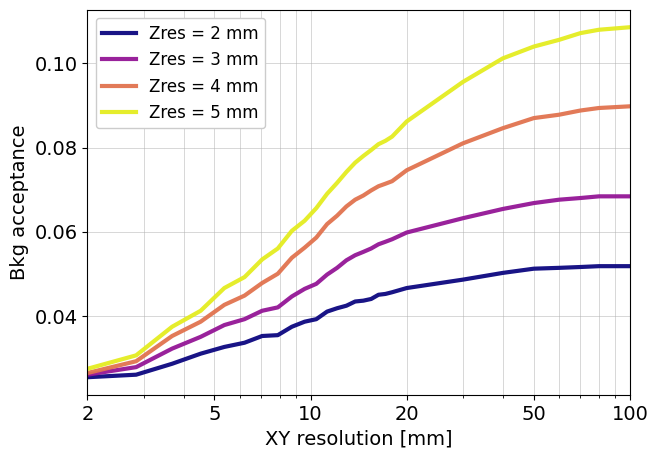

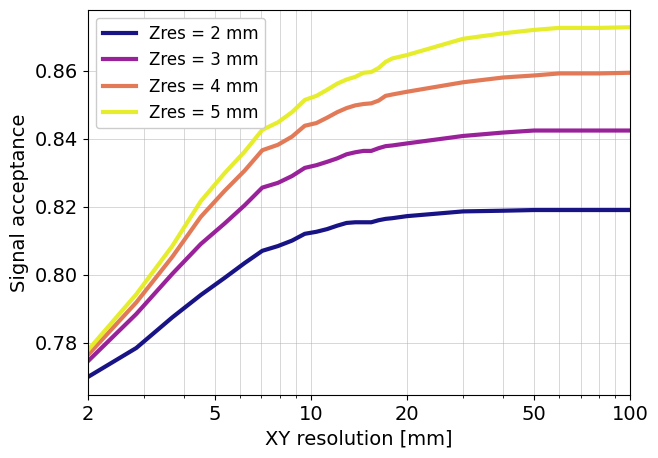

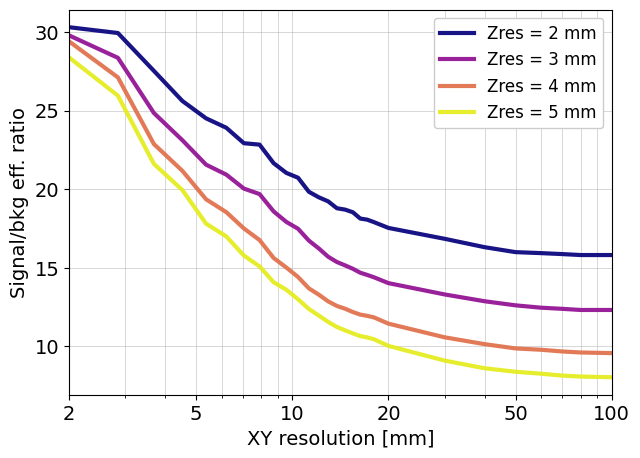

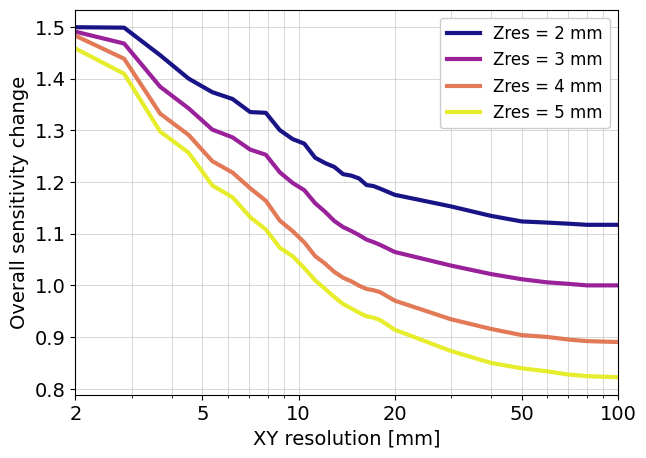

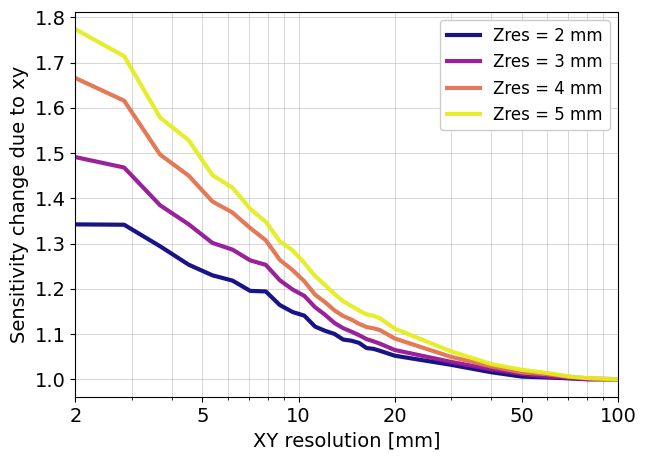

In [ ]:
num_lines = len(z_resolutions)
color_indices = np.linspace(0.,1.,num_lines)
colors = [np.array(cm.plasma(ci)) * 0.95 for ci in color_indices]
plt.rcParams['font.size']=14

zfid_idx = np.where(np.array(z_resolutions) == 3.)
xyfid_idx = np.where(np.array(xy_resolutions) == 100.)

bkg_acc_fid = xyres_list[zfid_idx[0][0]]['bkg_eff'][xyfid_idx[0][0]]
sig_acc_fid = xyres_list[zfid_idx[0][0]]['sig_eff'][xyfid_idx[0][0]]

print('Fiducial bkg acceptance: {:4.4} and signal acceptance: {:4.4}'.format(bkg_acc_fid, sig_acc_fid))


for i, zres in enumerate(z_resolutions):

    xyres = xyres_list[i]['xyres']
    bkg_eff = xyres_list[i]['bkg_eff']
    sig_eff = xyres_list[i]['sig_eff']
    
    
    plt.figure(1)
    plt.plot(xyres, bkg_eff, '-', color=colors[i], linewidth=3, label='Zres = {} mm'.format(int(zres)))
    plt.xlabel('XY resolution [mm]')
    plt.ylabel('Bkg acceptance')
    # plt.ylim(7.,30.)
    plt.xscale('log')
    plt.xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])
    plt.legend(loc='upper left', framealpha=1.,fontsize=12)
    plt.grid(which='both')
    plt.xlim(2.,100.)
    
    plt.figure(2)
    plt.plot(xyres, sig_eff, '-', color=colors[i], linewidth=3, label='Zres = {} mm'.format(int(zres)))
    plt.xlabel('XY resolution [mm]')
    plt.ylabel('Signal acceptance')
    # plt.ylim(7.,30.)
    plt.xscale('log')
    plt.xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])
    plt.legend(loc='upper left', framealpha=1.,fontsize=12)
    plt.grid(which='both')
    plt.xlim(2.,100.)
    
    
    plt.figure(3)
    plt.plot(xyres, sig_eff/bkg_eff, '-', color=colors[i], linewidth=3, label='Zres = {} mm'.format(int(zres)))
    plt.xlabel('XY resolution [mm]')
    plt.ylabel('Signal/bkg eff. ratio')
    # plt.ylim(7.,30.)
    plt.xscale('log')
    plt.xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])
    plt.legend(loc='upper right', framealpha=1., fontsize=12.)
    # plt.grid(which='both')
    # plt.grid()
    plt.xlim(2.,100.)
    
    
    plt.figure(4)
    
    # Use zres = 3, xyres = 100 as the fiducial case
    # Assume that sensitivity scales linearly with signal acceptance,
    # but like the sqrt of background. So, sensitivity change = sig_acc/sig_acc_fid * sqrt(bkg_acc_fid/bkg_acc)
    
    plt.xlabel('XY resolution [mm]')
    plt.ylabel('Overall sensitivity change')
    plt.plot(xyres, sig_eff/sig_acc_fid * np.sqrt(bkg_acc_fid/bkg_eff), color=colors[i], linewidth=3, label='Zres = {} mm'.format(int(zres)))

    plt.xscale('log')
    plt.xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])
    plt.xlim(2.,100.)
    plt.legend(loc='upper right', framealpha=1., fontsize=12.)
    
    
    plt.figure(5)
    
    # Use zres = 3, xyres = 100 as the fiducial case
    # Assume that sensitivity scales linearly with signal acceptance,
    # but like the sqrt of background. So, sensitivity change = sig_acc/sig_acc_fid * sqrt(bkg_acc_fid/bkg_acc)
    
    plt.xlabel('XY resolution [mm]')
    plt.ylabel('Sensitivity change due to xy')
    plt.plot(xyres, sig_eff/sig_eff[-1] * np.sqrt(bkg_eff[-1]/bkg_eff), color=colors[i], linewidth=3, label='Zres = {} mm'.format(int(zres)))

    plt.xscale('log')
    plt.xticks([2., 5.,10.,20., 50., 100.],['2','5','10','20','50','100'])
    plt.xlim(2.,100.)
    plt.legend(loc='upper right', framealpha=1., fontsize=12.)
    
    
    
for i in range(5):
    plt.figure(i+1)
    plt.grid(which='both',linewidth=0.5,alpha=0.7)
    if i+1==1:
        plt.savefig('plots/eff_vs_resolution_bkg_acceptance.png',dpi=200,bbox_inches='tight')
    if i+1==2:
        plt.savefig('plots/eff_vs_resolution_signal_acceptance.png',dpi=200,bbox_inches='tight')
    if i+1==3:
        plt.savefig('plots/eff_vs_resolution_sig_bkg_eff_ratio.png',dpi=200,bbox_inches='tight')
    if i+1==4:
        plt.savefig('plots/eff_vs_resolution_sensitivity_scaling_compared_to_zres_3mm.png',dpi=200,bbox_inches='tight')
    if i+1==5:
        plt.savefig('plots/eff_vs_resolution_sensitivity_scaling_compared_to_noxy_in_all_cases.png',dpi=200,bbox_inches='tight')
    

# Looking at cut efficiencies for Jingke

In [91]:
this_zres = 3. # mm
this_xyres = 100. # mm
num_evts = 5000


sig_ssms, bkg_ssms = ComputeSigandBkgEff(electrons_data,gammas_data,zres=this_zres,xyres=this_xyres,num_evts=num_evts)

NameError: name 'ComputeSigandBkgEff' is not defined

In [92]:
len(bkg_ssms)
print(len(bkg_ssms))
print(np.sum(bkg_ssms)/len(bkg_ssms))

NameError: name 'bkg_ssms' is not defined

NameError: name 'bkg_ssms' is not defined

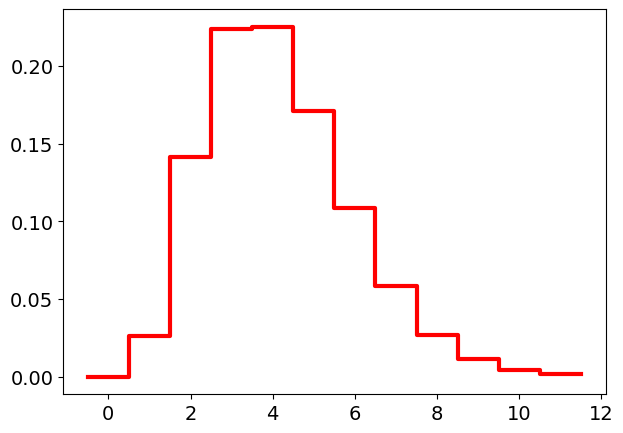

In [93]:
h1 = hl.hist(bkg_multiplicity, bins=np.linspace(-0.5,11.5,13))

hl.plot1d(h1 / len(bkg_multiplicity), linewidth=3, color='r', label='Gammas overall')

h2 = hl.hist(np.array(bkg_multiplicity)[bkg_ssms], bins=np.linspace(-0.5,11.5,13))
hl.plot1d(h2/len(bkg_multiplicity), linewidth=3, label='Gammas with SS/MS cut')


plt.legend(loc='lower right')


# plt.xlim(0.,10.)
# plt.ylim(0.,1.)
# plt.xlabel('Number of clusters in evt')
# plt.ylabel('Fraction of events')
# plt.title('Multiplicity for bkg events')
plt.yscale('log')
plt.xlabel('Number of clusters')
plt.ylabel('Number of events (arbitrary)')
plt.title('Multiplicity with SS/MS cut ($\sigma_{{z}}$,$\sigma_{{xy}}$ = ({}, {}) mm)'.format(int(this_zres), int(this_xyres)))




### For double-scatters, what is distance between individual scatters?

In [12]:
# Relevant arrays: 
#   - bkg_clusters
#   - bkg_multiplicity
#   - bkg_ssms

# Marwa?
mask = (np.array(bkg_multiplicity) == 2)
zcut = np.invert(bkg_3mm_cut)

# Get double-scatter clusters
clusters_ds = [cluster for i, cluster in enumerate(bkg_clusters) if mask[i]]
clusters_ds_zcut = [cluster for i, cluster in enumerate(bkg_clusters) if mask[i] & zcut[i]]





In [13]:
distances = []
energies_larger = []
energies_smaller = []

for cluster in clusters_ds:
    d_sq = (cluster['X'].iloc[0] - cluster['X'].iloc[1])**2 + \
        (cluster['Y'].iloc[0] - cluster['Y'].iloc[1])**2 + \
        (cluster['Z'].iloc[0] - cluster['Z'].iloc[1])**2
    d = np.sqrt(d_sq)
    distances.append(d)
    
    energies_larger.append(cluster['Energy'].iloc[0])
    energies_smaller.append(cluster['Energy'].iloc[1])
    
    
distances = np.array(distances)
energies_larger = np.array(energies_larger)
energies_smaller = np.array(energies_smaller)
    

In [14]:
distances_zcut = []

for cluster in clusters_ds_zcut:
    d_sq = (cluster['X'].iloc[0] - cluster['X'].iloc[1])**2 + \
        (cluster['Y'].iloc[0] - cluster['Y'].iloc[1])**2 + \
        (cluster['Z'].iloc[0] - cluster['Z'].iloc[1])**2
    d = np.sqrt(d_sq)
    distances_zcut.append(d)
    
    
distances_zcut = np.array(distances_zcut)

Distance = 2.53 mm
Distance = 0.586 mm


Text(0.5, 1.0, 'Gamma events with two clusters, with Z<3mm cut')

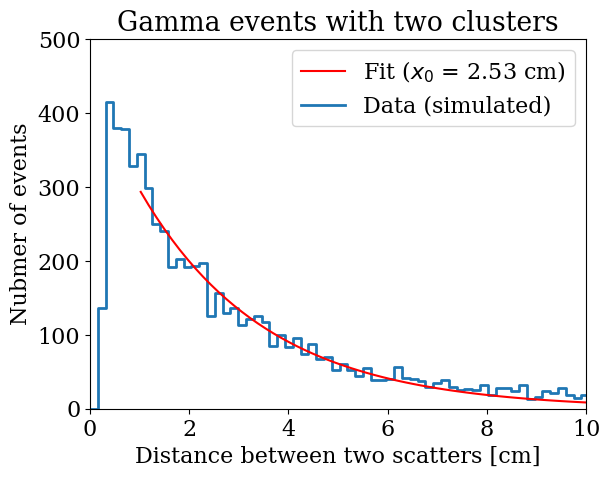

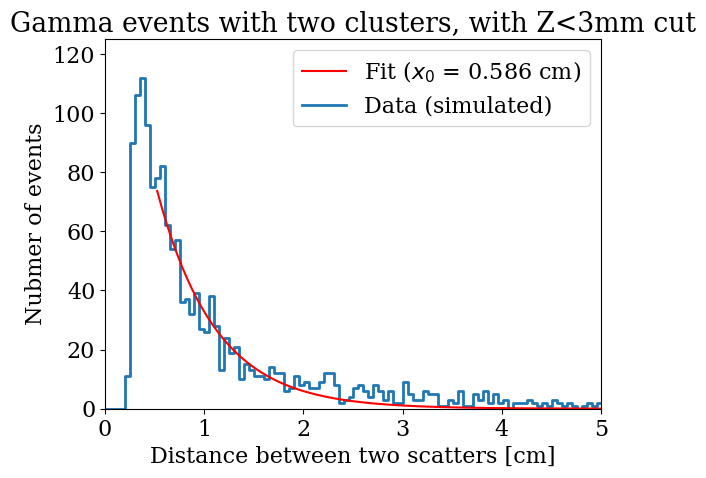

In [15]:
####################################################################
def Exp(x,A,tau):
    return A*np.exp(-x/tau)

####################################################################
def GetBinCenters(bins):
    return (bins[:-1] + bins[1:])/2.

####################################################################
from scipy.optimize import curve_fit

h_dist = hl.hist(distances/10, bins=np.linspace(0.,25.,160))

x = GetBinCenters(h_dist.bins[0])
y = h_dist.values

mask = (x>1.)&(x<10.)

p, popt = curve_fit(Exp, x[mask], y[mask], p0 = (2000.,5.))

yfit = Exp(x,*p)

hl.plot1d(h_dist, label='Data (simulated)', linewidth=2)

plt.plot(x[mask], yfit[mask], '-r', label=r'Fit ($x_0$ = {:3.3} cm)'.format(p[1]))

print('Distance = {:3.3} mm'.format(p[1]))

plt.xlim(0.,10.)
plt.xlabel('Distance between two scatters [cm]')
plt.ylabel('Nubmer of events')
plt.ylim(0.,500.)
plt.legend()

plt.title('Gamma events with two clusters')

plt.savefig('plots/distance_distribution_of_two_cluster_event_distances.png',dpi=100,bbox_inches='tight')


plt.figure(2)

h_dist_zcut = hl.hist(distances_zcut/10, bins=np.linspace(0.,25.,500))

x = GetBinCenters(h_dist_zcut.bins[0])
y = h_dist_zcut.values

mask = (x>0.5)&(x<10.)

p, popt = curve_fit(Exp, x[mask], y[mask], p0 = (2000.,5.))

yfit = Exp(x,*p)

hl.plot1d(h_dist_zcut, label='Data (simulated)', linewidth=2)

plt.plot(x[mask], yfit[mask], '-r', label=r'Fit ($x_0$ = {:3.3} cm)'.format(p[1]))

print('Distance = {:3.3} mm'.format(p[1]))

plt.xlim(0.,5.)
plt.xlabel('Distance between two scatters [cm]')
plt.ylabel('Nubmer of events')
plt.ylim(0.,125.)
plt.legend()

plt.title('Gamma events with two clusters, with Z<3mm cut')

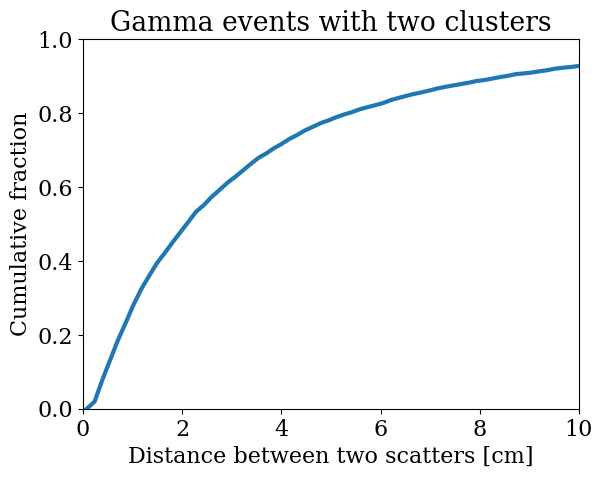

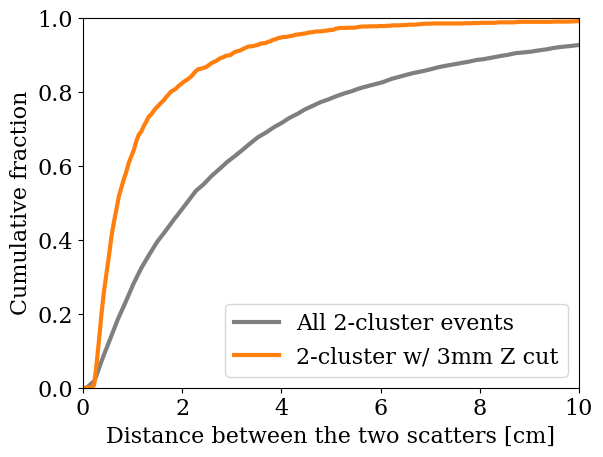

In [16]:
x = GetBinCenters(h_dist.bins[0])
y = np.cumsum(h_dist.values/np.sum(h_dist.values))


plt.plot(x,y, linewidth=3)
plt.xlim(0.,10.)
plt.ylim(0.,1.)

# plt.xlabel('Distance between two scatters [cm]')
plt.title('Gamma events with two clusters')

plt.xlabel('Distance between two scatters [cm]')
plt.ylabel('Cumulative fraction')
plt.savefig('plots/cumulative_distribution_of_two_cluster_event_distances.png',dpi=100,bbox_inches='tight')


plt.figure(2)

# Get the standard color wheel
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


x = GetBinCenters(h_dist.bins[0])
y = np.cumsum(h_dist.values/np.sum(h_dist.values))

plt.plot(x,y, linewidth=3, label='All 2-cluster events', color=colors[7])
plt.xlim(0.,10.)
plt.ylim(0.,1.)

h_dist_zcut = hl.hist(distances_zcut/10, bins=np.linspace(0.,25.,500))

x = GetBinCenters(h_dist_zcut.bins[0])
y = np.cumsum(h_dist_zcut.values/np.sum(h_dist_zcut.values))

plt.plot(x,y, linewidth=3, label='2-cluster w/ 3mm Z cut', color=colors[1])
plt.xlim(0.,10.)
plt.ylim(0.,1.)

# plt.plot(np.ones(10), np.linspace(0.,1.,10), '--k', linewidth=1)

plt.legend()

# plt.xlabel('Distance between two scatters [cm]')
# plt.title('Gamma events with two clusters, with Z<3mm cut')

plt.xlabel('Distance between the two scatters [cm]')
plt.ylabel('Cumulative fraction')
plt.savefig('plots/JINGKE_PAPER_cumulative_distribution_of_two_cluster_event_distances_with_zcut.pdf',bbox_inches='tight')


### For single-scatters, what is distance from origin?

In [ ]:
# Get single-scatter clusters
mask = np.array(bkg_multiplicity) == 1
clusters_ss = [cluster for i, cluster in enumerate(bkg_clusters) if mask[i]]

distances_ss = []
energies_ss = []

for cluster in clusters_ss:
    d_sq = (cluster['X'].iloc[0])**2 + \
        (cluster['Y'].iloc[0])**2 + \
        (cluster['Z'].iloc[0])**2
    d = np.sqrt(d_sq)
    distances_ss.append(d)
    
    energies_ss.append(cluster['Energy'].iloc[0])    
    
distances_ss = np.array(distances_ss)
energies_ss = np.array(energies_ss)


Distance = 80.7 mm


Text(0.5, 1.0, 'Gamma events with one cluster')

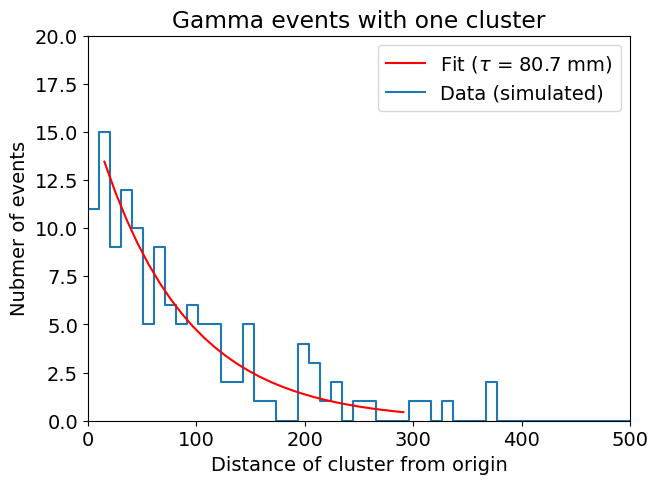

In [ ]:
h_dist = hl.hist(distances_ss, bins=np.linspace(0.,500.,50))

# hl.plot1d(h_dist, label='Data (simulated)')

x = GetBinCenters(h_dist.bins[0])
y = h_dist.values

mask = (x>10.)&(x<300)

p, popt = curve_fit(Exp, x[mask], y[mask], p0 = (200.,50.))

yfit = Exp(x,*p)

hl.plot1d(h_dist, label='Data (simulated)')

plt.plot(x[mask], yfit[mask], '-r', label=r'Fit ($\tau$ = {:3.3} mm)'.format(p[1]))

print('Distance = {:3.3} mm'.format(p[1]))

plt.xlim(0.,500.)
plt.xlabel('Distance of cluster from origin')
plt.ylabel('Nubmer of events')
plt.ylim(0.,20.)
plt.legend()

plt.title('Gamma events with one cluster')

# Incorporating diffusion

In [ ]:
D_L = 25 # cm^2/s, taken from the approximate asymptotic value shown in Fig. 9 in https://arxiv.org/abs/2303.13963 (Xenoscope paper)
D_T = 55 # cm^2/s, eyeballed from https://arxiv.org/abs/1609.04467 (EXO-200 paper)

def DiffSigma( time, D=D_T ):
    return np.sqrt(2*D*time)



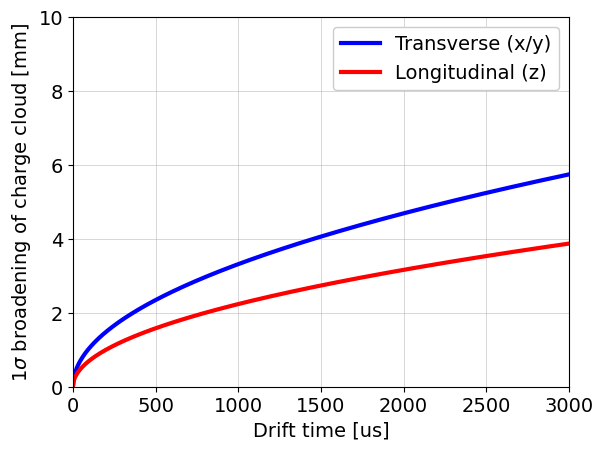

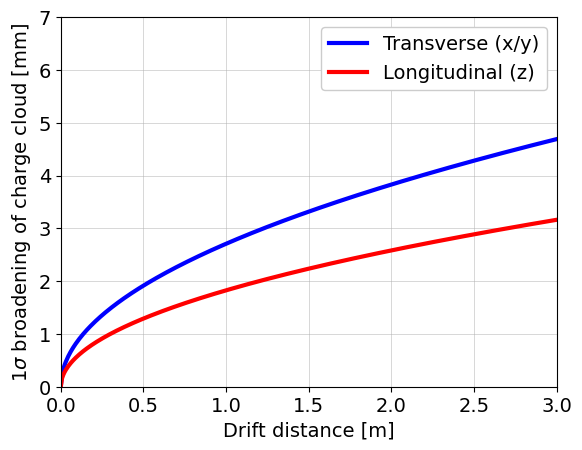

In [ ]:
drift_time = np.linspace(0.,0.005,1000) # time in seconds

transverse_diff = DiffSigma( drift_time, D_T )
longitudinal_diff = DiffSigma( drift_time, D_L)

plt.plot(drift_time*1e6, transverse_diff*10, '-b', linewidth=3, label='Transverse (x/y)')
plt.plot(drift_time*1e6, longitudinal_diff*10, '-r', linewidth=3., label='Longitudinal (z)')

plt.xlabel('Drift time [us]')
plt.ylabel('1$\sigma$ broadening of charge cloud [mm]')
plt.legend(framealpha=1.)
plt.grid(linewidth=0.5,alpha=0.7)
plt.xlim(0.,3000.)
plt.ylim(0.,10.)
plt.savefig('plots/diffusion_broadening_vs_drift_time.png',dpi=200,bbox_inches='tight')


plt.figure(2)

drift_velocity = 1.5 # mm/us
# drift_velocit2 = 2*drift_velocity

plt.plot(drift_time*1e6*drift_velocity/1000., transverse_diff*10, '-b', linewidth=3, label='Transverse (x/y)')
plt.plot(drift_time*1e6*drift_velocity/1000., longitudinal_diff*10, '-r', linewidth=3., label='Longitudinal (z)')

# plt.plot(drift_time*1e6*drift_velocit2/1000., transverse_diff*10, '--b', linewidth=3, label='Transverse (x/y)')
# plt.plot(drift_time*1e6*drift_velocit2/1000., longitudinal_diff*10, '--r', linewidth=3., label='Longitudinal (z)')


plt.xlabel('Drift distance [m]')
plt.ylabel('1$\sigma$ broadening of charge cloud [mm]')
plt.legend(framealpha=1.)
plt.grid(linewidth=0.5,alpha=0.7)
plt.xlim(0.,3.)
plt.ylim(0.,7.)
plt.savefig('plots/diffusion_broadening_vs_drift_distance.png',dpi=200,bbox_inches='tight')